# Comprehensive Experiment: 8 Configurations

This experiment tests all combinations of:
- **Agents**: Greedy vs UCB
- **Roles**: Price-Quantity assignment
- **Partner Prediction**: With vs Without

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Initial imports
import importlib
import params
import agents
import model

from model import NewsVendorModel

# ============================================================================
# EXPERIMENT GROUP 1: TEAM PLAYER SUPPLIER (Integrated Supply Chain)
# ============================================================================
print("=" * 80)
print("GROUP 1: TEAM PLAYER SUPPLIER MODE (Retailer-Only Metrics)")
print("=" * 80)

# Set to team player mode and recompute benchmarks
params.SUPPLIER_TEAM_PLAYER = True
params._compute_benchmarks()

print(f"\n🔍 Configuration:")
print(f"   SUPPLIER_TEAM_PLAYER: {params.SUPPLIER_TEAM_PLAYER}")
print(f"   Supplier action space: {params.action_space_c()}")
print(f"   Number of benchmarks: {len(params.PROFIT_OPTIMA_MAP)}\n")

experiments_team_player = [
    # (agent_types, use_partner_prediction, description)
    (['greedy', 'greedy', 'greedy'], False, 'Greedy-Greedy, No Prediction'),
    (['greedy', 'greedy', 'greedy'], True, 'Greedy-Greedy, With Prediction'),
    (['ucb', 'ucb', 'ucb'], False, 'UCB-UCB, No Prediction'),
    (['ucb', 'ucb', 'ucb'], True, 'UCB-UCB, With Prediction'),
    (['thompson', 'thompson', 'thompson'], False, 'Thompson-Thompson, No Prediction'),
    (['thompson', 'thompson', 'thompson'], True, 'Thompson-Thompson, With Prediction'),
    (['greedy', 'ucb', 'greedy'], False, 'Greedy(P)-UCB(Q), No Prediction'),
    (['greedy', 'ucb', 'greedy'], True, 'Greedy(P)-UCB(Q), With Prediction'),
    (['ucb', 'greedy', 'ucb'], False, 'UCB(P)-Greedy(Q), No Prediction'),
    (['ucb', 'greedy', 'ucb'], True, 'UCB(P)-Greedy(Q), With Prediction'),
    (['greedy', 'thompson', 'greedy'], False, 'Greedy(P)-Thompson(Q), No Prediction'),
    (['greedy', 'thompson', 'greedy'], True, 'Greedy(P)-Thompson(Q), With Prediction'),
    (['thompson', 'greedy', 'thompson'], False, 'Thompson(P)-Greedy(Q), No Prediction'),
    (['thompson', 'greedy', 'thompson'], True, 'Thompson(P)-Greedy(Q), With Prediction'),
    (['thompson', 'ucb', 'thompson'], False, 'Thompson(P)-UCB(Q), No Prediction'),
    (['thompson', 'ucb', 'thompson'], True, 'Thompson(P)-UCB(Q), With Prediction'),
    (['ucb', 'thompson', 'ucb'], False, 'UCB(P)-Thompson(Q), No Prediction'),
    (['ucb', 'thompson', 'ucb'], True, 'UCB(P)-Thompson(Q), With Prediction'),
]

team_player_results = []

for idx, (agent_types, use_prediction, description) in enumerate(experiments_team_player, 1):
    print(f"\n[{idx}/{len(experiments_team_player)}] {description}")
    print(f"  Price: {agent_types[0]}, Quantity: {agent_types[1]}, Prediction: {use_prediction}")
    
    params.USE_PARTNER_PREDICTION = use_prediction
    
    sim_model = NewsVendorModel(agent_type=agent_types)
    
    for i in range(params.ROUNDS):
        sim_model.step()
    
    model_df = sim_model.datacollector.get_model_vars_dataframe()
    agent_df = sim_model.datacollector.get_agent_vars_dataframe()
    
    df = agent_df.reset_index()
    price_data = df[df["AgentID"] == 1][["Step", "Action", "Reward"]].rename(columns={"Action": "Price"})
    qty_data = df[df["AgentID"] == 2][["Step", "Action"]].rename(columns={"Action": "Quantity"})
    supplier_data = df[df["AgentID"] == 3][["Step", "Action"]].rename(columns={"Action": "Cost"})
    
    combined_df = pd.merge(price_data, qty_data, on="Step")
    combined_df = pd.merge(combined_df, supplier_data, on="Step")
    combined_df = pd.merge(combined_df, model_df, left_on="Step", right_index=True)
    
    # Retailer metrics only
    final_regret = combined_df['Regret'].cumsum().iloc[-1]
    avg_profit = combined_df['Reward'].mean()
    final_price = combined_df['Price'].iloc[-100:].mean()
    final_quantity = combined_df['Quantity'].iloc[-100:].mean()
    price_std = combined_df['Price'].iloc[-100:].std()
    qty_std = combined_df['Quantity'].iloc[-100:].std()
    
    optimal_profit = params.PROFIT_OPTIMA_MAP.get(params.MANUFACTURING_COST, 0)
    
    team_player_results.append({
        'Config': description,
        'Price_Agent': agent_types[0],
        'Quantity_Agent': agent_types[1],
        'Prediction': use_prediction,
        'Cumulative_Regret': final_regret,
        'Avg_Profit': avg_profit,
        'Final_Price': final_price,
        'Final_Quantity': final_quantity,
        'Price_Std': price_std,
        'Qty_Std': qty_std,
        'Optimal_Profit': optimal_profit,
        'Combined_DF': combined_df.copy()
    })
    
    print(f"  ✓ Cumulative Regret: {final_regret:.2f}")
    print(f"  ✓ Average Profit: {avg_profit:.2f} (Optimal: {optimal_profit:.2f})")
    print(f"  ✓ Final Price: {final_price:.2f}, Quantity: {final_quantity:.1f}")

# ============================================================================
# EXPERIMENT GROUP 2: COMPETITIVE SUPPLIER (3-Agent Game)
# ============================================================================
print("\n" + "=" * 80)
print("GROUP 2: COMPETITIVE SUPPLIER MODE (Retailer & Supplier Profit)")
print("=" * 80)

# Switch to competitive mode and recompute benchmarks
params.SUPPLIER_TEAM_PLAYER = False
params._compute_benchmarks()

print(f"\n🔍 Supplier Configuration:")
print(f"   SUPPLIER_TEAM_PLAYER: {params.SUPPLIER_TEAM_PLAYER}")
print(f"   SUPPLIER_MAX_COST (ceiling): {params.SUPPLIER_MAX_COST:.2f}")
print(f"   Supplier step size: {params.C_STEP_SIZE:.2f}")
print(f"   SUPPLIER_OPTIMAL_COST: {params.SUPPLIER_OPTIMAL_COST:.2f}")
print(f"   Supplier action space size: {len(params.action_space_c())} actions")
print(f"   Number of benchmarks: {len(params.PROFIT_OPTIMA_MAP)}\n")

experiments_competitive = [
    # (agent_types, use_partner_prediction, description)
    # 1. Homogeneous Baselines (3 x 2 = 6 with/without info sharing)
    (['greedy', 'greedy', 'greedy'], False, 'All-Greedy'),
    (['greedy', 'greedy', 'greedy'], True, 'All-Greedy, Info Sharing'),
    (['ucb', 'ucb', 'ucb'], False, 'All-UCB'),
    (['ucb', 'ucb', 'ucb'], True, 'All-UCB, Info Sharing'),
    (['thompson', 'thompson', 'thompson'], False, 'All-Thompson'),
    (['thompson', 'thompson', 'thompson'], True, 'All-Thompson, Info Sharing'),
    
    # 2. Role Isolation - Vary Supplier (6)
    (['greedy', 'greedy', 'ucb'], False, 'Greedy Retailers, UCB Supplier'),
    (['greedy', 'greedy', 'thompson'], False, 'Greedy Retailers, Thompson Supplier'),
    (['ucb', 'ucb', 'greedy'], False, 'UCB Retailers, Greedy Supplier'),
    (['ucb', 'ucb', 'thompson'], False, 'UCB Retailers, Thompson Supplier'),
    (['thompson', 'thompson', 'greedy'], False, 'Thompson Retailers, Greedy Supplier'),
    (['thompson', 'thompson', 'ucb'], False, 'Thompson Retailers, UCB Supplier'),
    
    # 3. Heterogeneous Retailers - Mix P/Q (6)
    (['greedy', 'ucb', 'greedy'], False, 'Greedy(P)-UCB(Q), Greedy(S)'),
    (['greedy', 'thompson', 'greedy'], False, 'Greedy(P)-Thompson(Q), Greedy(S)'),
    (['ucb', 'greedy', 'ucb'], False, 'UCB(P)-Greedy(Q), UCB(S)'),
    (['ucb', 'thompson', 'ucb'], False, 'UCB(P)-Thompson(Q), UCB(S)'),
    (['thompson', 'greedy', 'thompson'], False, 'Thompson(P)-Greedy(Q), Thompson(S)'),
    (['thompson', 'ucb', 'thompson'], False, 'Thompson(P)-UCB(Q), Thompson(S)'),
]

competitive_results = []

for idx, (agent_types, use_prediction, description) in enumerate(experiments_competitive, 1):
    print(f"\n[{idx}/{len(experiments_competitive)}] {description}")
    print(f"  Price: {agent_types[0]}, Quantity: {agent_types[1]}, Supplier: {agent_types[2]}, Prediction: {use_prediction}")
    
    params.USE_PARTNER_PREDICTION = use_prediction
    
    sim_model = NewsVendorModel(agent_type=agent_types)
    
    for i in range(params.ROUNDS):
        sim_model.step()
    
    model_df = sim_model.datacollector.get_model_vars_dataframe()
    agent_df = sim_model.datacollector.get_agent_vars_dataframe()
    
    df = agent_df.reset_index()
    price_data = df[df["AgentID"] == 1][["Step", "Action", "Reward", "Cummulative Regret"]].rename(
        columns={"Action": "Price", "Reward": "Retailer_Profit", "Cummulative Regret": "Retailer_Cumulative_Regret"})
    qty_data = df[df["AgentID"] == 2][["Step", "Action"]].rename(columns={"Action": "Quantity"})
    supplier_data = df[df["AgentID"] == 3][["Step", "Action", "Reward"]].rename(
        columns={"Action": "Cost", "Reward": "Supplier_Profit"})
    
    combined_df = pd.merge(price_data, qty_data, on="Step")
    combined_df = pd.merge(combined_df, supplier_data, on="Step")
    combined_df = pd.merge(combined_df, model_df, left_on="Step", right_index=True)
    
    # Calculate metrics for both retailer and supplier
    retailer_cumulative_regret = combined_df['Retailer_Cumulative_Regret'].iloc[-1]
    avg_retailer_profit = combined_df['Retailer_Profit'].mean()
    avg_supplier_profit = combined_df['Supplier_Profit'].mean()
    final_price = combined_df['Price'].iloc[-100:].mean()
    final_quantity = combined_df['Quantity'].iloc[-100:].mean()
    final_cost = combined_df['Cost'].iloc[-100:].mean()
    price_std = combined_df['Price'].iloc[-100:].std()
    qty_std = combined_df['Quantity'].iloc[-100:].std()
    cost_std = combined_df['Cost'].iloc[-100:].std()
    
    optimal_retailer_profit = params.PROFIT_OPTIMA_MAP.get(final_cost, 0)
    
    competitive_results.append({
        'Config': description,
        'Price_Agent': agent_types[0],
        'Quantity_Agent': agent_types[1],
        'Supplier_Agent': agent_types[2],
        'Prediction': use_prediction,
        'Retailer_Cumulative_Regret': retailer_cumulative_regret,
        'Avg_Retailer_Profit': avg_retailer_profit,
        'Avg_Supplier_Profit': avg_supplier_profit,
        'Total_Supply_Chain_Profit': avg_retailer_profit + avg_supplier_profit,
        'Final_Price': final_price,
        'Final_Quantity': final_quantity,
        'Final_Cost': final_cost,
        'Price_Std': price_std,
        'Qty_Std': qty_std,
        'Cost_Std': cost_std,
        'Optimal_Retailer_Profit': optimal_retailer_profit,
        'Combined_DF': combined_df.copy()
    })
    
    print(f"  ✓ Retailer - Regret: {retailer_cumulative_regret:.2f}, Avg Profit: {avg_retailer_profit:.2f}")
    print(f"  ✓ Supplier - Avg Profit: {avg_supplier_profit:.2f}")
    print(f"  ✓ Total Supply Chain Profit: {(avg_retailer_profit + avg_supplier_profit):.2f}")
    print(f"  ✓ Final - Price: {final_price:.2f}, Quantity: {final_quantity:.1f}, Cost: {final_cost:.2f}")

# ============================================================================
# EXPERIMENT GROUP 3: PRICE CEILING SENSITIVITY ANALYSIS
# ============================================================================
print("\n" + "=" * 80)
print("GROUP 3: PRICE CEILING SENSITIVITY ANALYSIS")
print("=" * 80)

# Run best configurations with different price ceilings
price_ceilings = [6, 10, 15]  # 15 is the baseline already run
price_ceiling_results = []

# Select best 3 configurations from baseline (ceiling=15)
best_retailer_config = min(competitive_results, key=lambda x: x['Retailer_Cumulative_Regret'])
best_total_config = max(competitive_results, key=lambda x: x['Total_Supply_Chain_Profit'])
best_supplier_config = max(competitive_results, key=lambda x: x['Avg_Supplier_Profit'])

configs_to_test = [
    (best_retailer_config['Price_Agent'], best_retailer_config['Quantity_Agent'], 
     best_retailer_config['Supplier_Agent'], best_retailer_config['Prediction'], 
     f"Best Retailer: {best_retailer_config['Config']}"),
    (best_total_config['Price_Agent'], best_total_config['Quantity_Agent'], 
     best_total_config['Supplier_Agent'], best_total_config['Prediction'], 
     f"Best Total: {best_total_config['Config']}"),
    (best_supplier_config['Price_Agent'], best_supplier_config['Quantity_Agent'], 
     best_supplier_config['Supplier_Agent'], best_supplier_config['Prediction'], 
     f"Best Supplier: {best_supplier_config['Config']}")
]

for ceiling in price_ceilings:
    # Skip ceiling=15 as it's already computed
    if ceiling == 15:
        for price_agent, qty_agent, supp_agent, pred, desc in configs_to_test:
            # Find the matching result from baseline
            matching = [r for r in competitive_results 
                       if r['Price_Agent'] == price_agent 
                       and r['Quantity_Agent'] == qty_agent 
                       and r['Supplier_Agent'] == supp_agent
                       and r['Prediction'] == pred]
            if matching:
                result = matching[0].copy()
                result['Price_Ceiling'] = 15
                result['Config_Type'] = desc.split(':')[0]
                price_ceiling_results.append(result)
        continue
    
    print(f"\n{'='*80}")
    print(f"Testing with SUPPLIER_MAX_COST = {ceiling}")
    print(f"{'='*80}")
    
    # Temporarily change the price ceiling
    original_ceiling = params.SUPPLIER_MAX_COST
    params.SUPPLIER_MAX_COST = ceiling
    params._compute_benchmarks()  # Recompute with new ceiling
    
    for idx, (price_agent, qty_agent, supp_agent, pred, desc) in enumerate(configs_to_test, 1):
        agent_types = [price_agent, qty_agent, supp_agent]
        
        print(f"\n[{idx}/{len(configs_to_test)}] {desc} (Ceiling={ceiling})")
        print(f"  Price: {agent_types[0]}, Quantity: {agent_types[1]}, Supplier: {agent_types[2]}")
        
        params.USE_PARTNER_PREDICTION = pred
        
        sim_model = NewsVendorModel(agent_type=agent_types)
        
        for i in range(params.ROUNDS):
            sim_model.step()
        
        model_df = sim_model.datacollector.get_model_vars_dataframe()
        agent_df = sim_model.datacollector.get_agent_vars_dataframe()
        
        df = agent_df.reset_index()
        price_data = df[df["AgentID"] == 1][["Step", "Action", "Reward", "Cummulative Regret"]].rename(
            columns={"Action": "Price", "Reward": "Retailer_Profit", "Cummulative Regret": "Retailer_Cumulative_Regret"})
        qty_data = df[df["AgentID"] == 2][["Step", "Action"]].rename(columns={"Action": "Quantity"})
        supplier_data = df[df["AgentID"] == 3][["Step", "Action", "Reward"]].rename(
            columns={"Action": "Cost", "Reward": "Supplier_Profit"})
        
        combined_df = pd.merge(price_data, qty_data, on="Step")
        combined_df = pd.merge(combined_df, supplier_data, on="Step")
        combined_df = pd.merge(combined_df, model_df, left_on="Step", right_index=True)
        
        retailer_cumulative_regret = combined_df['Retailer_Cumulative_Regret'].iloc[-1]
        avg_retailer_profit = combined_df['Retailer_Profit'].mean()
        avg_supplier_profit = combined_df['Supplier_Profit'].mean()
        final_price = combined_df['Price'].iloc[-100:].mean()
        final_quantity = combined_df['Quantity'].iloc[-100:].mean()
        final_cost = combined_df['Cost'].iloc[-100:].mean()
        
        price_ceiling_results.append({
            'Config': desc,
            'Config_Type': desc.split(':')[0],
            'Price_Agent': price_agent,
            'Quantity_Agent': qty_agent,
            'Supplier_Agent': supp_agent,
            'Prediction': pred,
            'Price_Ceiling': ceiling,
            'Retailer_Cumulative_Regret': retailer_cumulative_regret,
            'Avg_Retailer_Profit': avg_retailer_profit,
            'Avg_Supplier_Profit': avg_supplier_profit,
            'Total_Supply_Chain_Profit': avg_retailer_profit + avg_supplier_profit,
            'Final_Price': final_price,
            'Final_Quantity': final_quantity,
            'Final_Cost': final_cost,
            'Combined_DF': combined_df.copy()
        })
        
        print(f"  ✓ Retailer - Regret: {retailer_cumulative_regret:.2f}, Avg Profit: {avg_retailer_profit:.2f}")
        print(f"  ✓ Supplier - Avg Profit: {avg_supplier_profit:.2f}")
        print(f"  ✓ Total Supply Chain Profit: {(avg_retailer_profit + avg_supplier_profit):.2f}")
        print(f"  ✓ Final Cost: {final_cost:.2f}")
    
    # Restore original ceiling
    params.SUPPLIER_MAX_COST = original_ceiling
    params._compute_benchmarks()

print("=" * 80)

print("\n" + "=" * 80)
print("\n" + "=" * 80)
print("=" * 80)

print("ALL EXPERIMENTS COMPLETED!")


Computing optimal benchmarks (this may take a moment)...
Retailer optimal at manufacturing cost (c=2.00): price=17.50, quantity=40
GROUP 1: TEAM PLAYER SUPPLIER MODE (Retailer-Only Metrics)
Computing optimal benchmarks (this may take a moment)...
Retailer optimal at manufacturing cost (c=2.00): price=17.50, quantity=40

🔍 Configuration:
   SUPPLIER_TEAM_PLAYER: True
   Supplier action space: [2.]
   Number of benchmarks: 1


[1/18] Greedy-Greedy, No Prediction
  Price: greedy, Quantity: greedy, Prediction: False
  ✓ Cumulative Regret: 73678.02
  ✓ Average Profit: 334.04 (Optimal: 537.82)
  ✓ Final Price: 19.54, Quantity: 36.1

[2/18] Greedy-Greedy, With Prediction
  Price: greedy, Quantity: greedy, Prediction: True
  ✓ Cumulative Regret: 72459.62
  ✓ Average Profit: 338.39 (Optimal: 537.82)
  ✓ Final Price: 18.25, Quantity: 34.6

[3/18] UCB-UCB, No Prediction
  Price: ucb, Quantity: ucb, Prediction: False
  ✓ Cumulative Regret: 48419.95
  ✓ Average Profit: 403.47 (Optimal: 537.82)
  ✓ 


📊 GRAPH 1: Team Player Supplier - WITHOUT Prediction (REGRET)
Compare pure algorithm performance and mixed configurations



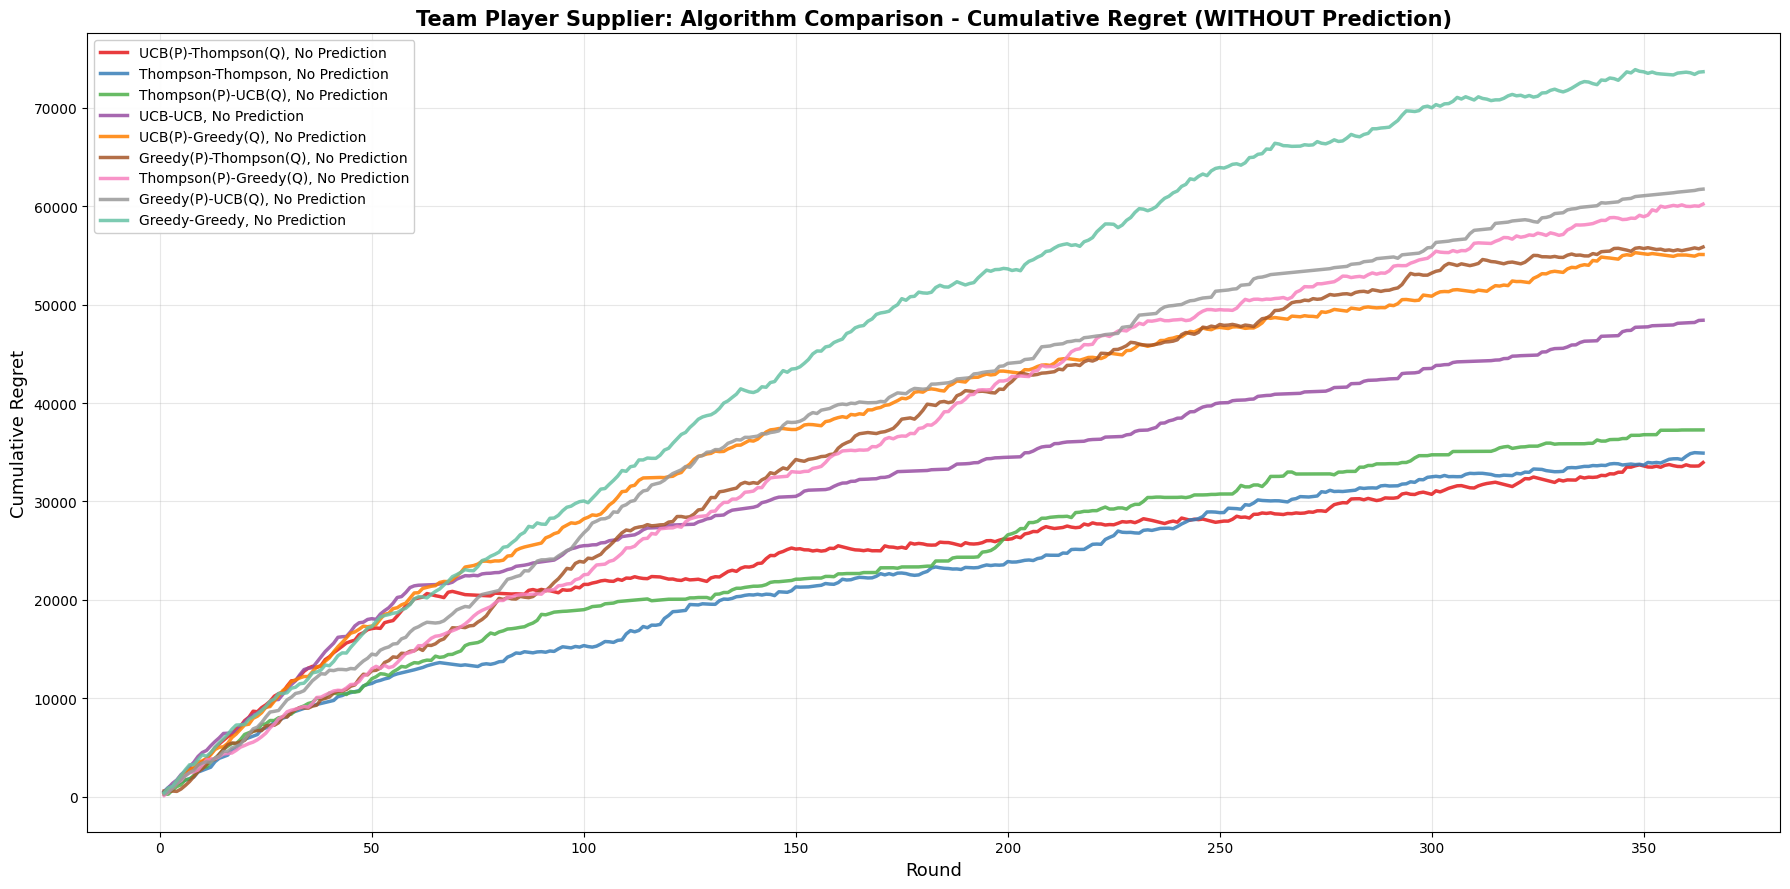

✓ Displayed 9 configurations without prediction


In [2]:
# ============================================================================
# VISUALIZATION 1: Team Player - WITHOUT Prediction (Algorithm Comparison)
# ============================================================================

print("\n📊 GRAPH 1: Team Player Supplier - WITHOUT Prediction (REGRET)")
print("Compare pure algorithm performance and mixed configurations\n")

fig, ax = plt.subplots(figsize=(18, 9))

# Filter only no-prediction results
no_pred_results = [r for r in team_player_results if not r['Prediction']]

# Sort by cumulative regret (best to worst for legend order)
no_pred_results = sorted(no_pred_results, key=lambda x: x['Cumulative_Regret'])

# Use distinct colors - ColorBrewer Set1 palette with good contrast
color_list = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', 
              '#a65628', '#f781bf', '#999999', '#66c2a5']
colors = color_list[:len(no_pred_results)]

for idx, result in enumerate(no_pred_results):
    df = result['Combined_DF']
    cumulative_regret = df['Regret'].cumsum()
    
    ax.plot(df['Step'], cumulative_regret, 
            label=result['Config'], 
            color=colors[idx],
            linewidth=2.5,
            alpha=0.85)

ax.set_xlabel('Round', fontsize=13)
ax.set_ylabel('Cumulative Regret', fontsize=13)
ax.set_title('Team Player Supplier: Algorithm Comparison - Cumulative Regret (WITHOUT Prediction)', fontsize=15, fontweight='bold')
ax.legend(loc='upper left', fontsize=10, framealpha=0.95, ncol=1)
ax.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()
print(f"✓ Displayed {len(no_pred_results)} configurations without prediction")



📊 GRAPH 3: Team Player Supplier - Complete Overview
All 18 configurations together



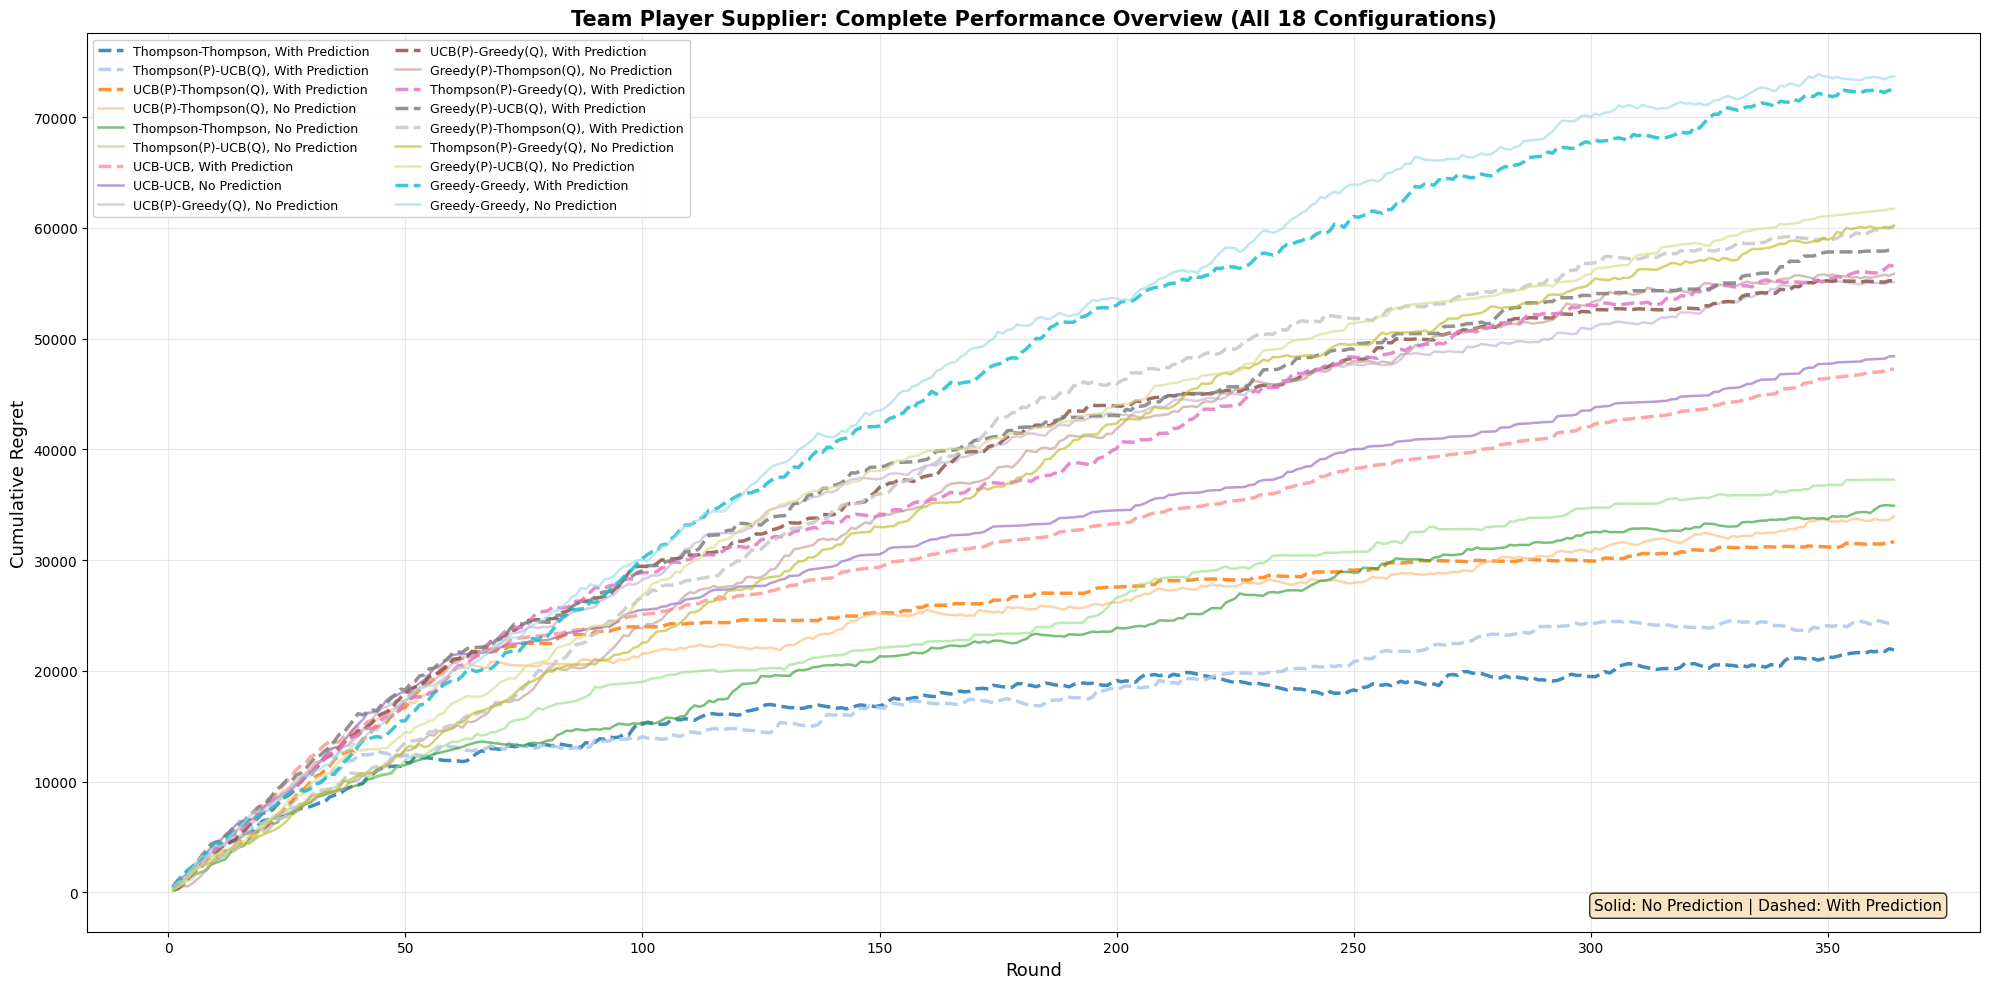

✓ Displayed all 18 team player configurations


In [3]:
# ============================================================================
# VISUALIZATION 3: Team Player - Complete Overview (All Configurations)
# ============================================================================

print("\n📊 GRAPH 3: Team Player Supplier - Complete Overview")
print("All 18 configurations together\n")

fig, ax = plt.subplots(figsize=(20, 10))

# Sort by cumulative regret for legend order
sorted_results = sorted(team_player_results, key=lambda x: x['Cumulative_Regret'])

colors = plt.cm.tab20(np.linspace(0, 1, len(sorted_results)))

for idx, result in enumerate(sorted_results):
    df = result['Combined_DF']
    cumulative_regret = df['Regret'].cumsum()
    
    linestyle = '--' if result['Prediction'] else '-'
    linewidth = 2.5 if result['Prediction'] else 1.8
    alpha = 0.85 if result['Prediction'] else 0.65
    
    ax.plot(df['Step'], cumulative_regret, 
            label=result['Config'], 
            color=colors[idx],
            linestyle=linestyle,
            linewidth=linewidth,
            alpha=alpha)

ax.set_xlabel('Round', fontsize=13)
ax.set_ylabel('Cumulative Regret', fontsize=13)
ax.set_title('Team Player Supplier: Complete Performance Overview (All 18 Configurations)', fontsize=15, fontweight='bold')
ax.legend(loc='upper left', fontsize=9, framealpha=0.95, ncol=2)
ax.grid(True, alpha=0.3)

# Add annotation about line styles
ax.text(0.98, 0.02, 'Solid: No Prediction | Dashed: With Prediction', 
        transform=ax.transAxes, fontsize=11, 
        verticalalignment='bottom', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()

plt.show()
print("✓ Displayed all 18 team player configurations")



📊 GRAPH 4: Team Player Supplier - WITHOUT Prediction (PROFIT)
Compare cumulative profit for pure algorithms and mixed configurations

Optimal profit per round: $537.82
Optimal cumulative profit (365 days): $195,766.25



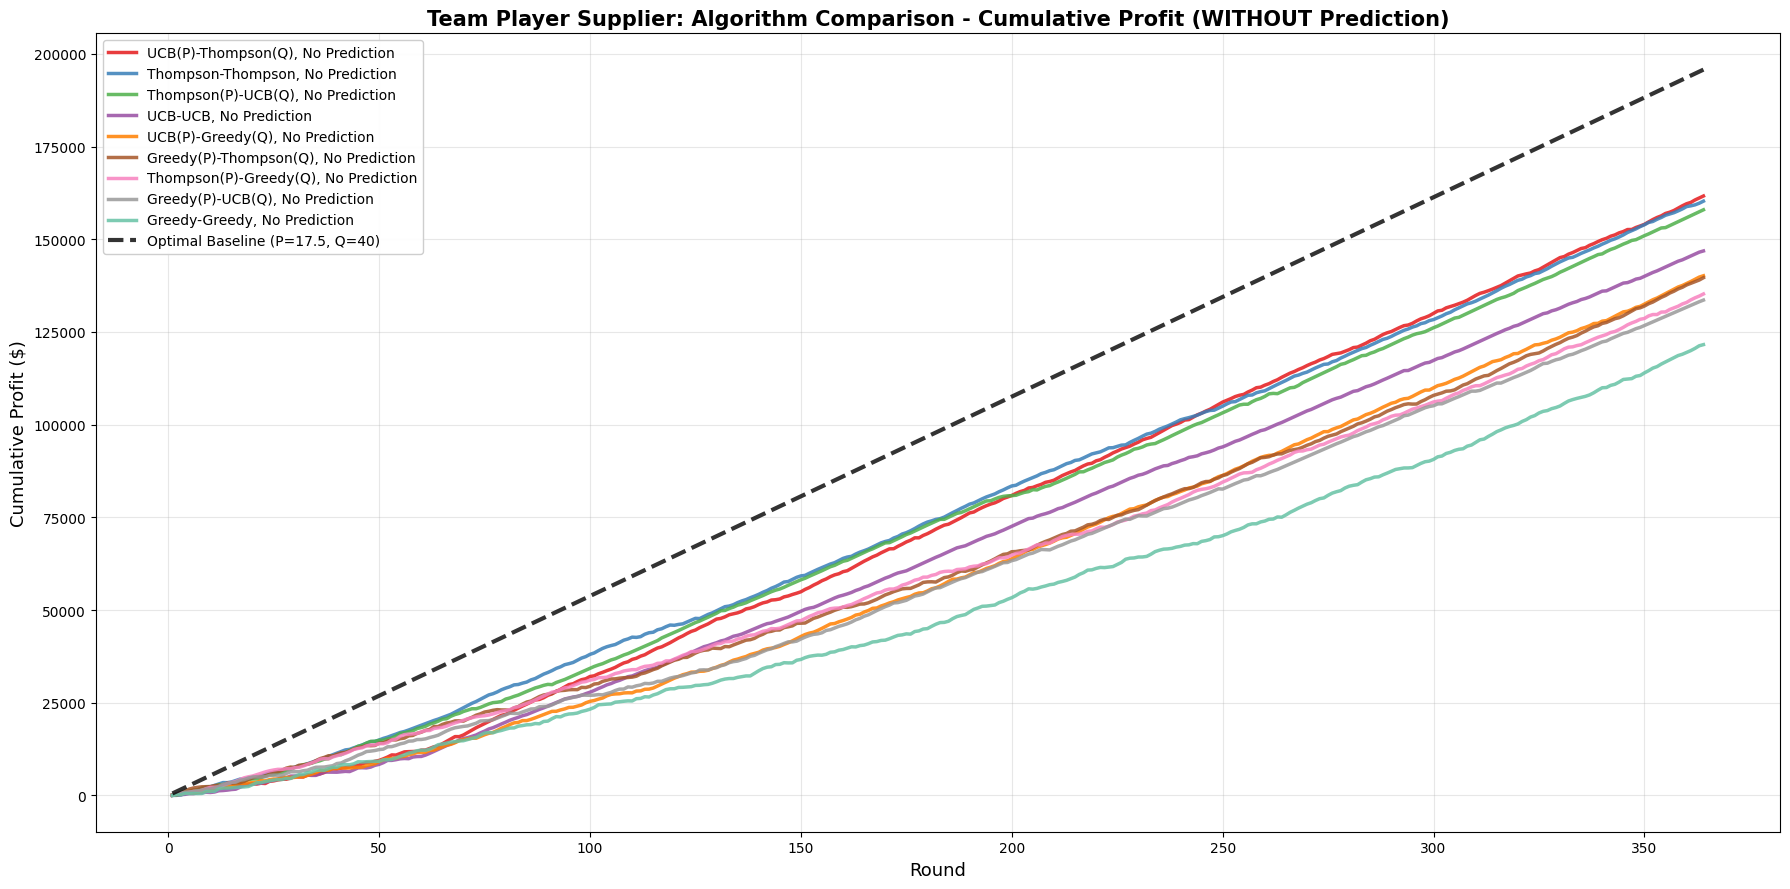

✓ Displayed 9 configurations without prediction


In [4]:
# ============================================================================
# VISUALIZATION 4: Team Player - WITHOUT Prediction (PROFIT)
# ============================================================================

print("\n📊 GRAPH 4: Team Player Supplier - WITHOUT Prediction (PROFIT)")
print("Compare cumulative profit for pure algorithms and mixed configurations\n")

# Calculate optimal profit baseline
optimal_profit_per_round = params.PROFIT_OPTIMA_MAP.get(params.MANUFACTURING_COST, 0)
sample_df = team_player_results[0]['Combined_DF']
optimal_cumulative_profit = [optimal_profit_per_round * (i + 1) for i in range(len(sample_df))]

print(f"Optimal profit per round: ${optimal_profit_per_round:.2f}")
print(f"Optimal cumulative profit (365 days): ${optimal_cumulative_profit[-1]:,.2f}\n")

fig, ax = plt.subplots(figsize=(18, 9))

# Filter only no-prediction results
no_pred_results = [r for r in team_player_results if not r['Prediction']]

# Sort by average profit (best to worst for legend order)
no_pred_results = sorted(no_pred_results, key=lambda x: x['Avg_Profit'], reverse=True)

# Use distinct colors - avoid similar shades
color_list = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', 
              '#a65628', '#f781bf', '#999999', '#66c2a5']
colors = color_list[:len(no_pred_results)]

for idx, result in enumerate(no_pred_results):
    df = result['Combined_DF']
    cumulative_profit = df['Reward'].cumsum()
    
    ax.plot(df['Step'], cumulative_profit, 
            label=result['Config'], 
            color=colors[idx],
            linewidth=2.5,
            alpha=0.85)

# Add optimal profit baseline
ax.plot(sample_df['Step'], optimal_cumulative_profit, 
        color='black', linestyle='--', linewidth=3, 
        label=f'Optimal Baseline (P=17.5, Q=40)', alpha=0.8, zorder=100)

ax.set_xlabel('Round', fontsize=13)
ax.set_ylabel('Cumulative Profit ($)', fontsize=13)
ax.set_title('Team Player Supplier: Algorithm Comparison - Cumulative Profit (WITHOUT Prediction)', fontsize=15, fontweight='bold')
ax.legend(loc='upper left', fontsize=10, framealpha=0.95, ncol=1)
ax.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()
print(f"✓ Displayed {len(no_pred_results)} configurations without prediction")



📊 GRAPH 6: Team Player Supplier - Complete Overview (PROFIT)
Cumulative profit for all 18 configurations



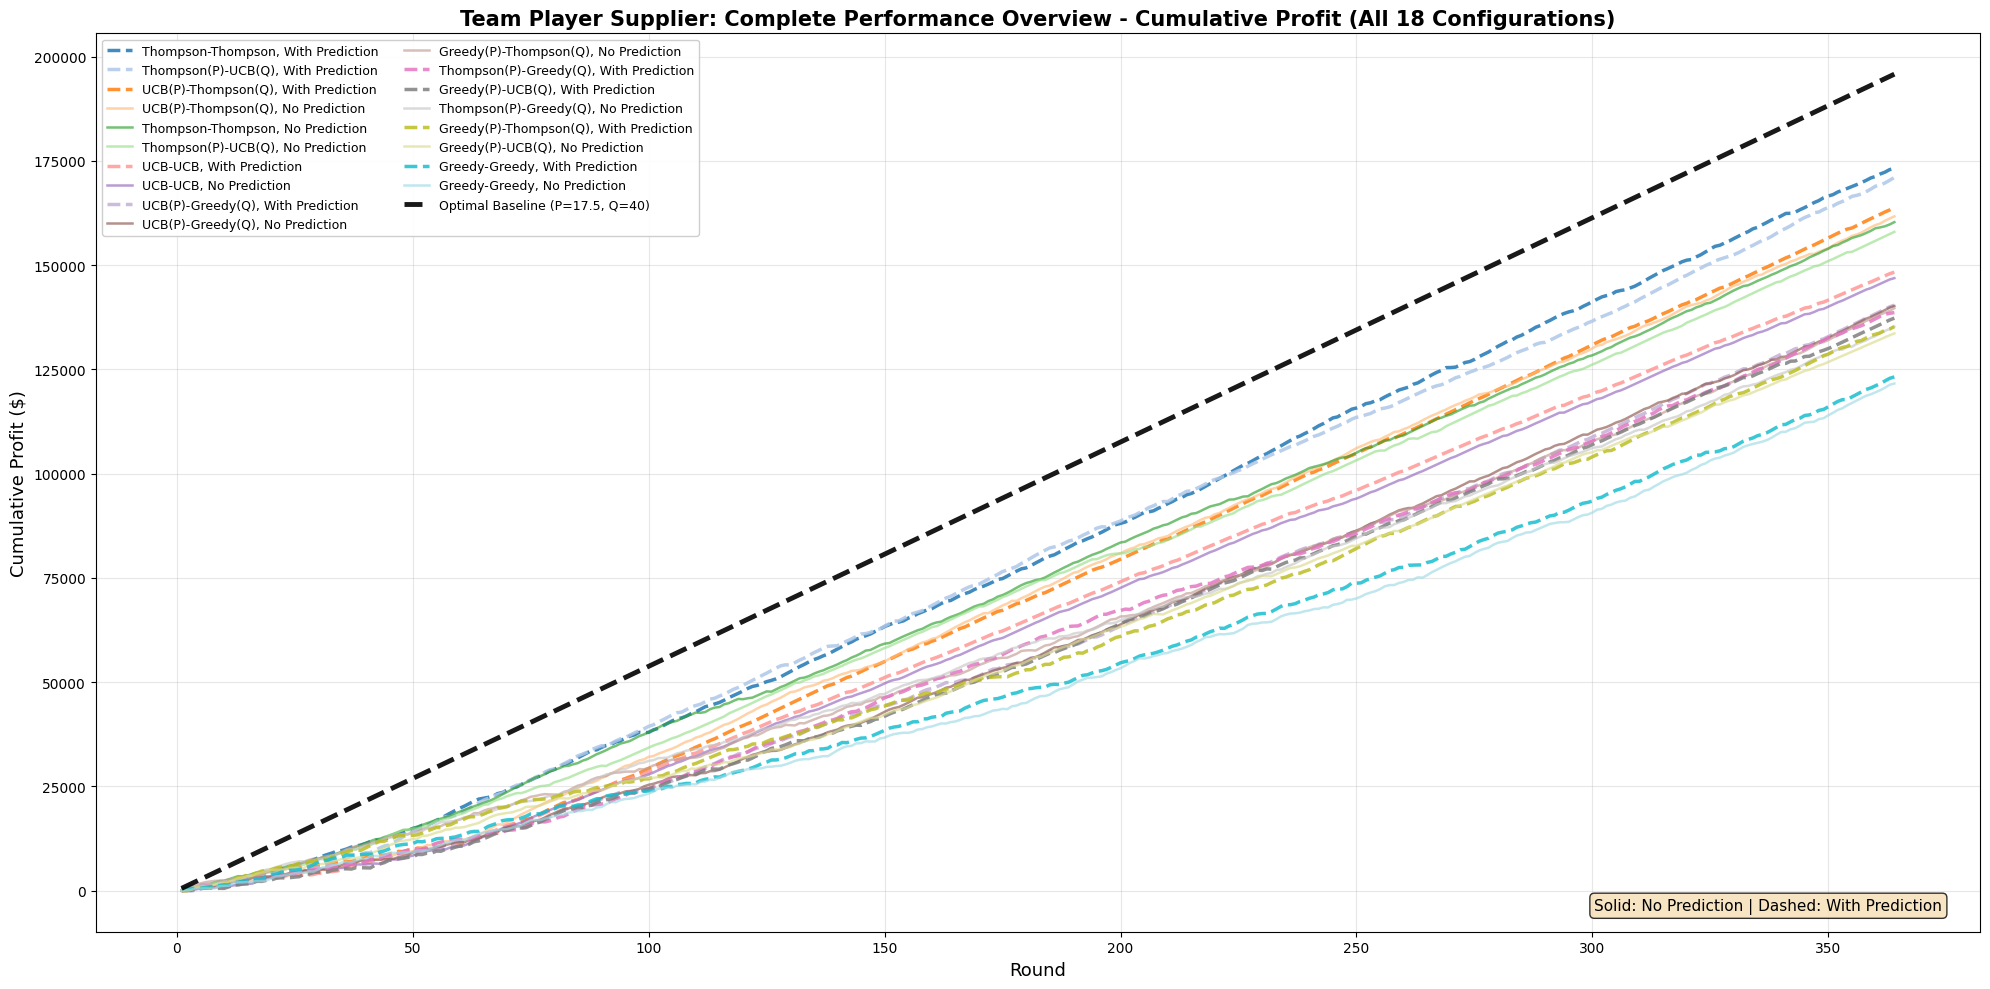

✓ Displayed all 18 team player configurations


In [5]:
# ============================================================================
# VISUALIZATION 6: Team Player - Complete Overview (PROFIT - All Configurations)
# ============================================================================

print("\n📊 GRAPH 6: Team Player Supplier - Complete Overview (PROFIT)")
print("Cumulative profit for all 18 configurations\n")

fig, ax = plt.subplots(figsize=(20, 10))

# Sort by average profit for legend order (best to worst)
sorted_results = sorted(team_player_results, key=lambda x: x['Avg_Profit'], reverse=True)

colors = plt.cm.tab20(np.linspace(0, 1, len(sorted_results)))

for idx, result in enumerate(sorted_results):
    df = result['Combined_DF']
    cumulative_profit = df['Reward'].cumsum()
    
    linestyle = '--' if result['Prediction'] else '-'
    linewidth = 2.5 if result['Prediction'] else 1.8
    alpha = 0.85 if result['Prediction'] else 0.65
    
    ax.plot(df['Step'], cumulative_profit, 
            label=result['Config'], 
            color=colors[idx],
            linestyle=linestyle,
            linewidth=linewidth,
            alpha=alpha)

# Add optimal profit baseline
ax.plot(sample_df['Step'], optimal_cumulative_profit, 
        color='black', linestyle='--', linewidth=3.5, 
        label=f'Optimal Baseline (P=17.5, Q=40)', alpha=0.9, zorder=100)

ax.set_xlabel('Round', fontsize=13)
ax.set_ylabel('Cumulative Profit ($)', fontsize=13)
ax.set_title('Team Player Supplier: Complete Performance Overview - Cumulative Profit (All 18 Configurations)', fontsize=15, fontweight='bold')
ax.legend(loc='upper left', fontsize=9, framealpha=0.95, ncol=2)
ax.grid(True, alpha=0.3)

# Add annotation about line styles
ax.text(0.98, 0.02, 'Solid: No Prediction | Dashed: With Prediction', 
        transform=ax.transAxes, fontsize=11, 
        verticalalignment='bottom', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()

plt.show()
print("✓ Displayed all 18 team player configurations")



📊 GRAPH 5: Team Player Supplier - Effect of Partner Prediction (PROFIT)
Compare cumulative profit WITH vs WITHOUT prediction for each algorithm



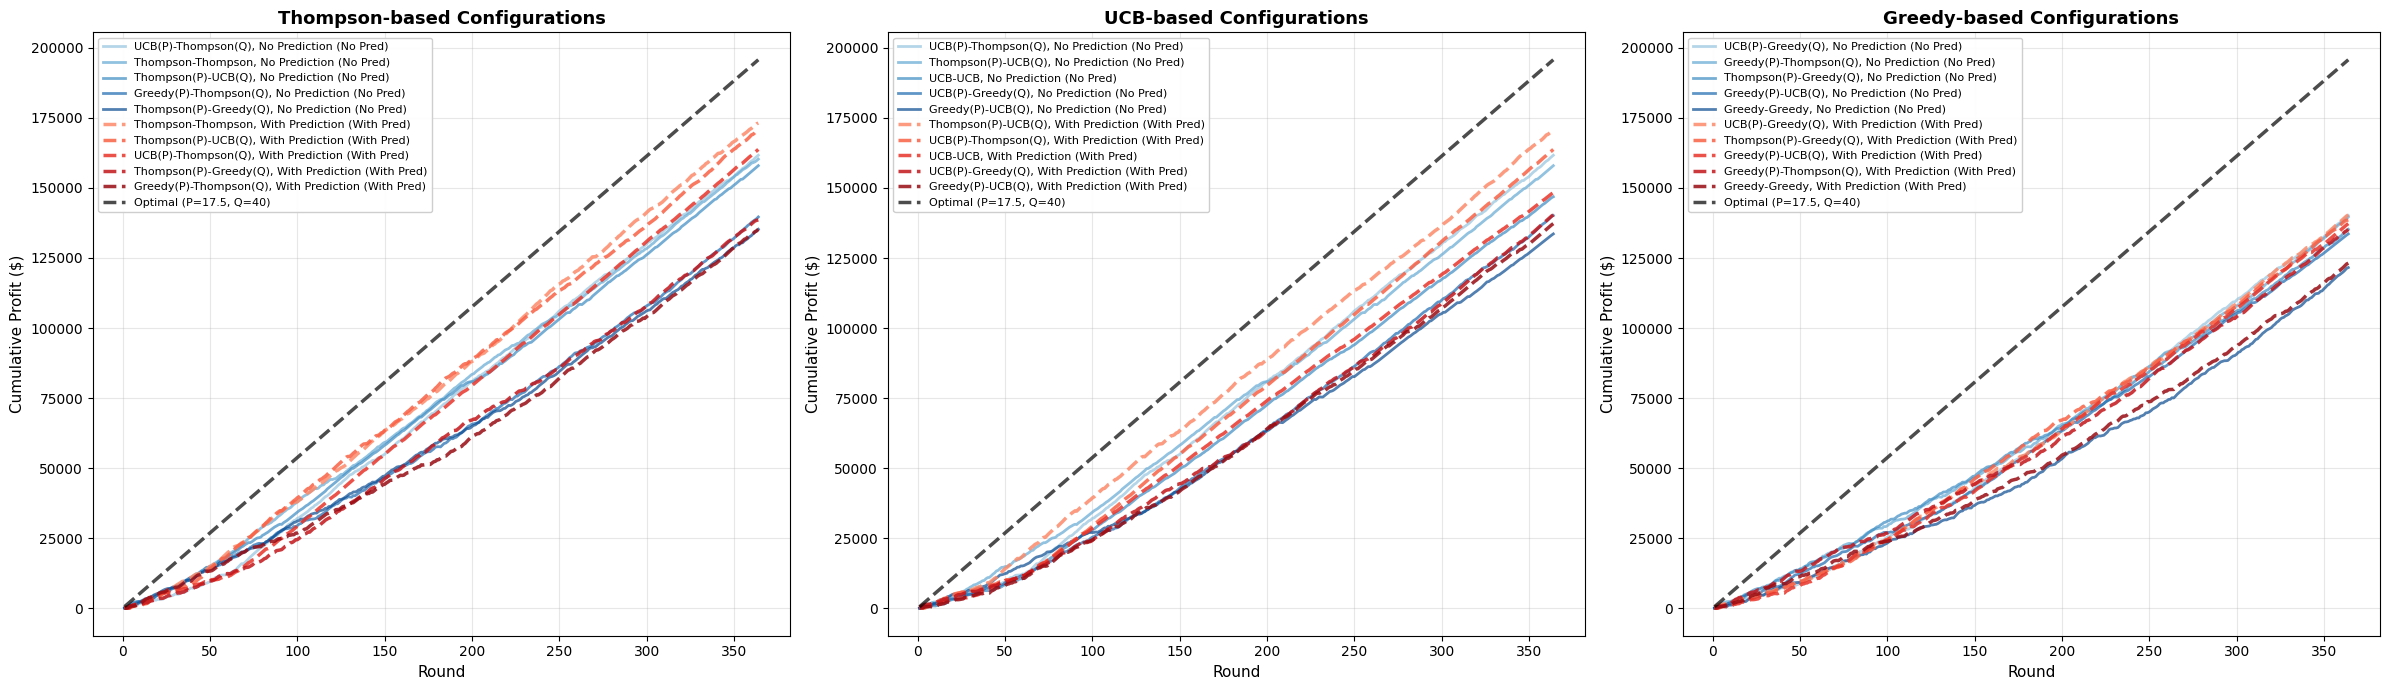

✓ Displayed prediction effect for Thompson, UCB, and Greedy


In [6]:
# ============================================================================
# VISUALIZATION 5: Team Player - Effect of Prediction (PROFIT - 3 Subplots)
# ============================================================================

print("\n📊 GRAPH 5: Team Player Supplier - Effect of Partner Prediction (PROFIT)")
print("Compare cumulative profit WITH vs WITHOUT prediction for each algorithm\n")

fig, axes = plt.subplots(1, 3, figsize=(24, 7))

algorithms = ['Thompson', 'UCB', 'Greedy']

for idx, algo in enumerate(algorithms):
    ax = axes[idx]
    
    # Filter results for this algorithm
    algo_results = [r for r in team_player_results if algo in r['Config']]
    
    # Separate by prediction and sort by profit (best to worst)
    no_pred = sorted([r for r in algo_results if not r['Prediction']], key=lambda x: x['Avg_Profit'], reverse=True)
    with_pred = sorted([r for r in algo_results if r['Prediction']], key=lambda x: x['Avg_Profit'], reverse=True)
    
    # Plot without prediction
    colors_no = plt.cm.Blues(np.linspace(0.4, 0.9, len(no_pred)))
    for i, result in enumerate(no_pred):
        df = result['Combined_DF']
        cumulative_profit = df['Reward'].cumsum()
        ax.plot(df['Step'], cumulative_profit, 
                label=f"{result['Config']} (No Pred)", 
                color=colors_no[i],
                linestyle='-',
                linewidth=2,
                alpha=0.7)
    
    # Plot with prediction
    colors_yes = plt.cm.Reds(np.linspace(0.4, 0.9, len(with_pred)))
    for i, result in enumerate(with_pred):
        df = result['Combined_DF']
        cumulative_profit = df['Reward'].cumsum()
        ax.plot(df['Step'], cumulative_profit, 
                label=f"{result['Config']} (With Pred)", 
                color=colors_yes[i],
                linestyle='--',
                linewidth=2.5,
                alpha=0.85)
    
    # Add optimal profit baseline
    ax.plot(sample_df['Step'], optimal_cumulative_profit, 
            color='black', linestyle='--', linewidth=2.5, 
            label=f'Optimal (P=17.5, Q=40)', alpha=0.7, zorder=100)
    
    ax.set_xlabel('Round', fontsize=11)
    ax.set_ylabel('Cumulative Profit ($)', fontsize=11)
    ax.set_title(f'{algo}-based Configurations', fontsize=13, fontweight='bold')
    ax.legend(loc='upper left', fontsize=8, framealpha=0.95)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Displayed prediction effect for Thompson, UCB, and Greedy")


📊 GRAPH 2: Team Player Supplier - Effect of Partner Prediction
Compare WITH vs WITHOUT prediction for each algorithm



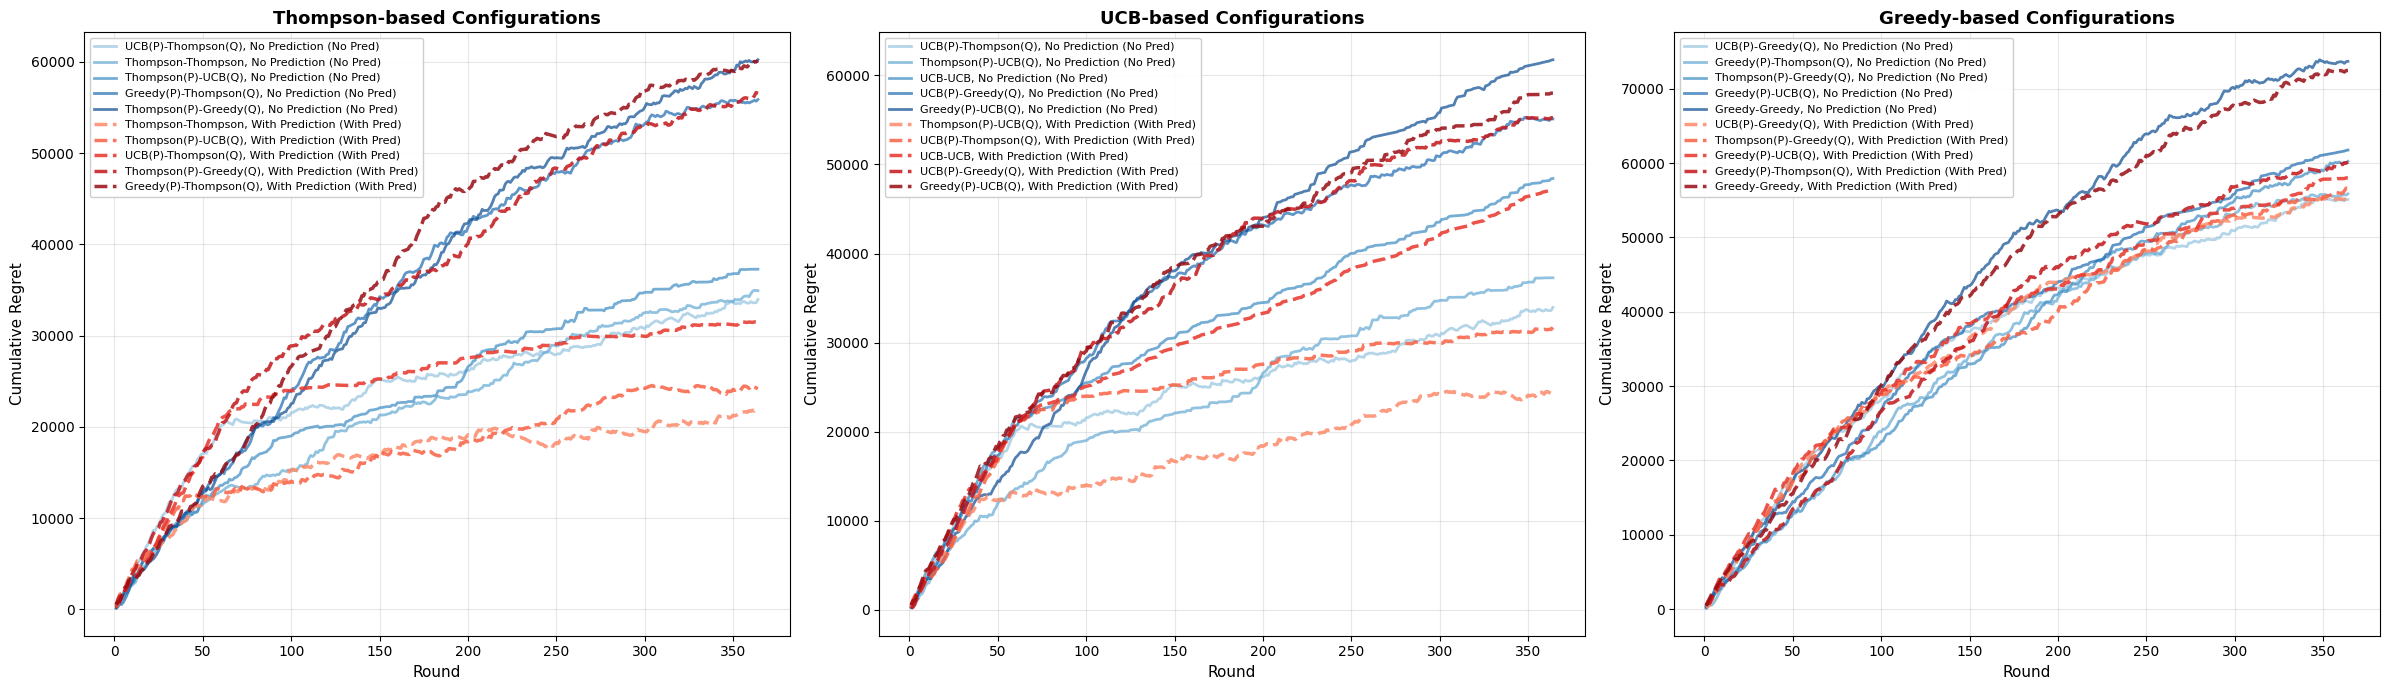

✓ Displayed prediction effect for Thompson, UCB, and Greedy


In [7]:
# ============================================================================
# VISUALIZATION 2: Team Player - Effect of Prediction (3 Subplots)
# ============================================================================

print("\n📊 GRAPH 2: Team Player Supplier - Effect of Partner Prediction")
print("Compare WITH vs WITHOUT prediction for each algorithm\n")

fig, axes = plt.subplots(1, 3, figsize=(24, 7))

algorithms = ['Thompson', 'UCB', 'Greedy']

for idx, algo in enumerate(algorithms):
    ax = axes[idx]
    
    # Filter results for this algorithm
    algo_results = [r for r in team_player_results if algo in r['Config']]
    
    # Separate by prediction and sort by regret (best to worst)
    no_pred = sorted([r for r in algo_results if not r['Prediction']], key=lambda x: x['Cumulative_Regret'])
    with_pred = sorted([r for r in algo_results if r['Prediction']], key=lambda x: x['Cumulative_Regret'])
    
    # Plot without prediction
    colors_no = plt.cm.Blues(np.linspace(0.4, 0.9, len(no_pred)))
    for i, result in enumerate(no_pred):
        df = result['Combined_DF']
        cumulative_regret = df['Regret'].cumsum()
        ax.plot(df['Step'], cumulative_regret, 
                label=f"{result['Config']} (No Pred)", 
                color=colors_no[i],
                linestyle='-',
                linewidth=2,
                alpha=0.7)
    
    # Plot with prediction
    colors_yes = plt.cm.Reds(np.linspace(0.4, 0.9, len(with_pred)))
    for i, result in enumerate(with_pred):
        df = result['Combined_DF']
        cumulative_regret = df['Regret'].cumsum()
        ax.plot(df['Step'], cumulative_regret, 
                label=f"{result['Config']} (With Pred)", 
                color=colors_yes[i],
                linestyle='--',
                linewidth=2.5,
                alpha=0.85)
    
    ax.set_xlabel('Round', fontsize=11)
    ax.set_ylabel('Cumulative Regret', fontsize=11)
    ax.set_title(f'{algo}-based Configurations', fontsize=13, fontweight='bold')
    ax.legend(loc='upper left', fontsize=8, framealpha=0.95)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Displayed prediction effect for Thompson, UCB, and Greedy")


📊 GRAPH 7: Competitive Supplier - Homogeneous Baselines (Retailer Regret)
Compare All-Greedy, All-UCB, All-Thompson



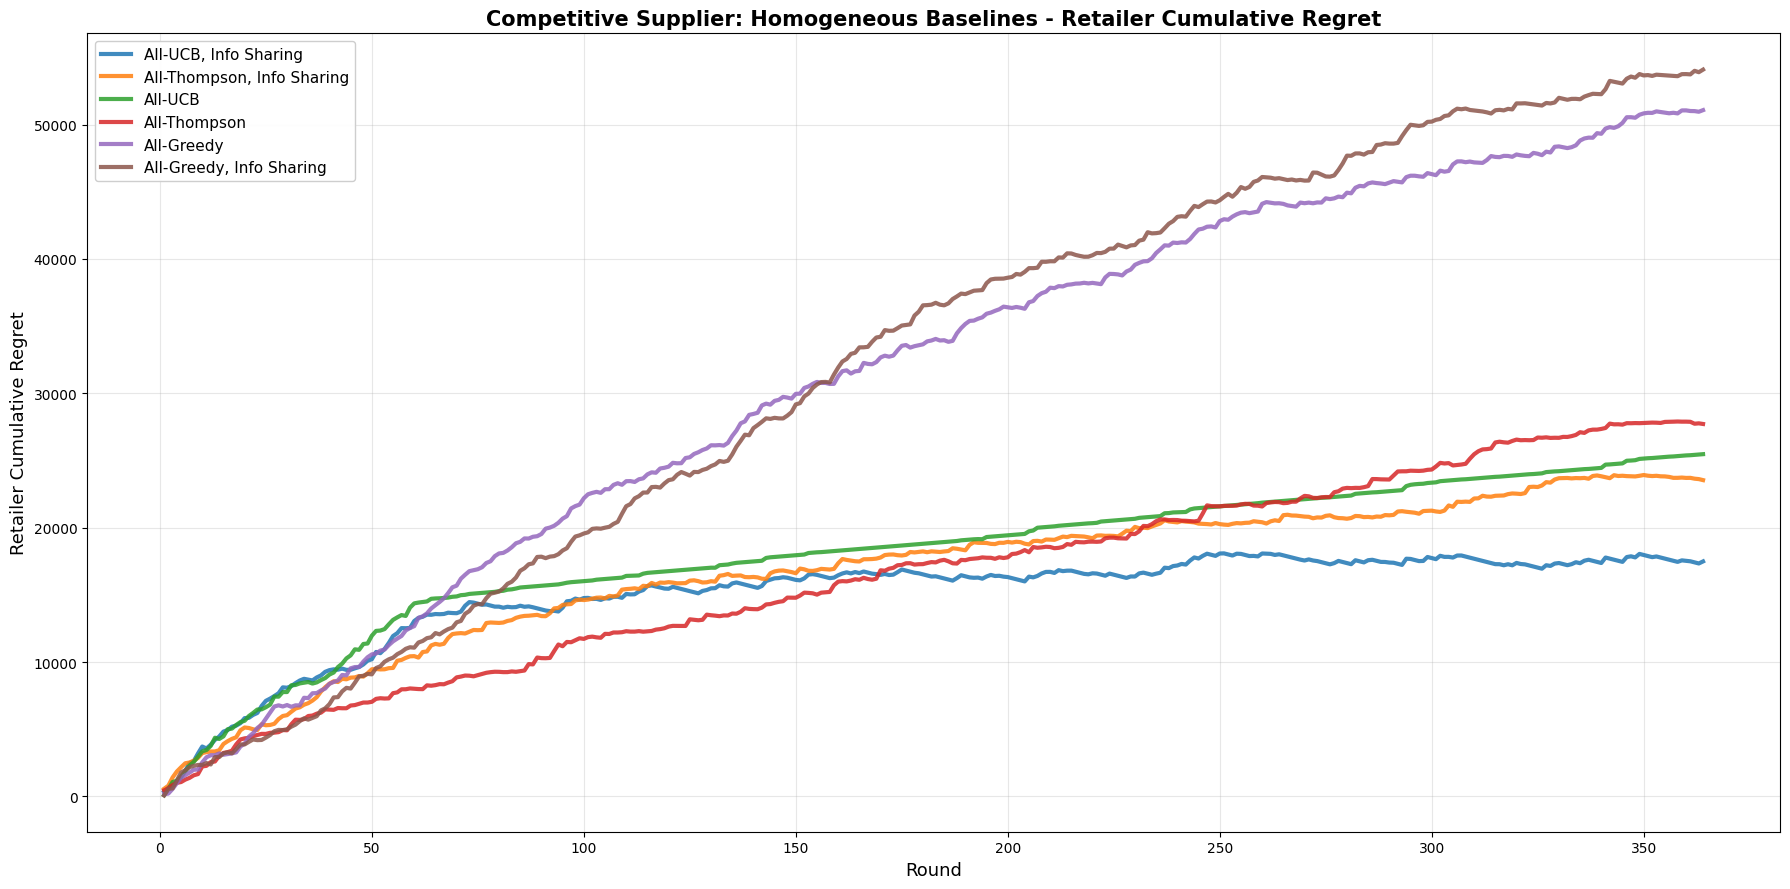

✓ Displayed 6 homogeneous configurations


In [8]:
# ============================================================================
# VISUALIZATION 7: Competitive Supplier - Homogeneous Baselines (REGRET)
# ============================================================================

print("\n📊 GRAPH 7: Competitive Supplier - Homogeneous Baselines (Retailer Regret)")
print("Compare All-Greedy, All-UCB, All-Thompson\n")

fig, ax = plt.subplots(figsize=(18, 9))

# Filter homogeneous configurations (all 3 agents same type)
homogeneous = [r for r in competitive_results if r['Price_Agent'] == r['Quantity_Agent'] == r['Supplier_Agent']]
homogeneous = sorted(homogeneous, key=lambda x: x['Retailer_Cumulative_Regret'])

colors = ['#e41a1c', '#377eb8', '#4daf4a']

for idx, result in enumerate(homogeneous):
    df = result['Combined_DF']
    
    ax.plot(df['Step'], df['Retailer_Cumulative_Regret'], 
            label=result['Config'], 
            
            linewidth=3,
            alpha=0.85)

ax.set_xlabel('Round', fontsize=13)
ax.set_ylabel('Retailer Cumulative Regret', fontsize=13)
ax.set_title('Competitive Supplier: Homogeneous Baselines - Retailer Cumulative Regret', fontsize=15, fontweight='bold')
ax.legend(loc='upper left', fontsize=11, framealpha=0.95)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"✓ Displayed {len(homogeneous)} homogeneous configurations")


📊 GRAPH 7b: Competitive Supplier - Information Sharing Effect (REGRET)
Compare homogeneous configs with and without information sharing



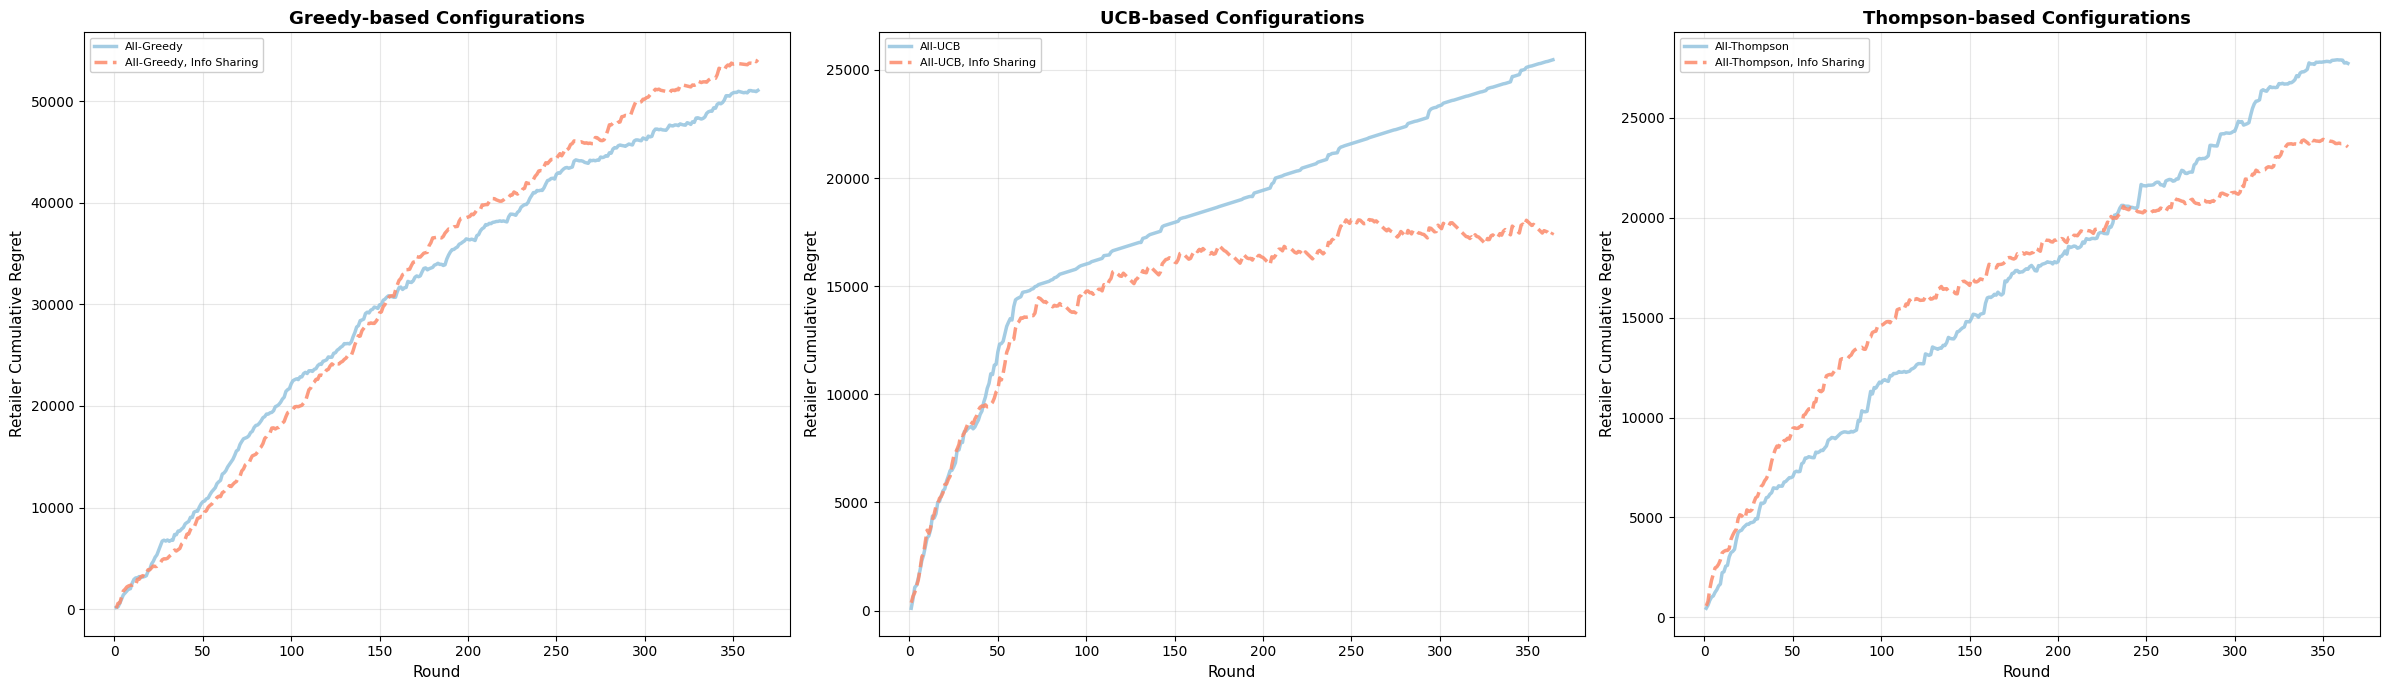

✓ Displayed information sharing effect for all homogeneous configurations


In [9]:
# ============================================================================
# VISUALIZATION 7b: Information Sharing Effect (Like Team Player Prediction)
# ============================================================================

print("\n📊 GRAPH 7b: Competitive Supplier - Information Sharing Effect (REGRET)")
print("Compare homogeneous configs with and without information sharing\n")

fig, axes = plt.subplots(1, 3, figsize=(24, 7))

algorithms = ['greedy', 'ucb', 'thompson']
titles = ['Greedy-based Configurations', 'UCB-based Configurations', 'Thompson-based Configurations']

for ax, algo, title in zip(axes, algorithms, titles):
    # Filter for this algorithm (homogeneous only)
    algo_results = [r for r in competitive_results 
                    if r['Price_Agent'] == r['Quantity_Agent'] == r['Supplier_Agent'] == algo]
    
    # Separate with/without info sharing
    without_sharing = [r for r in algo_results if not r['Prediction']]
    with_sharing = [r for r in algo_results if r['Prediction']]
    
    # Sort by retailer regret
    without_sharing = sorted(without_sharing, key=lambda x: x['Retailer_Cumulative_Regret'])
    with_sharing = sorted(with_sharing, key=lambda x: x['Retailer_Cumulative_Regret'])
    
    # Plot WITHOUT information sharing
    colors_no = plt.cm.Blues(np.linspace(0.4, 0.9, len(without_sharing)))
    for i, result in enumerate(without_sharing):
        df = result['Combined_DF']
        ax.plot(df['Step'], df['Retailer_Cumulative_Regret'], 
                label=f"{result['Config']}", 
                color=colors_no[i],
                linestyle='-',
                linewidth=2.5,
                alpha=0.85)
    
    # Plot WITH information sharing
    colors_yes = plt.cm.Reds(np.linspace(0.4, 0.9, len(with_sharing)))
    for i, result in enumerate(with_sharing):
        df = result['Combined_DF']
        ax.plot(df['Step'], df['Retailer_Cumulative_Regret'], 
                label=f"{result['Config']}", 
                color=colors_yes[i],
                linestyle='--',
                linewidth=2.5,
                alpha=0.85)
    
    ax.set_xlabel('Round', fontsize=11)
    ax.set_ylabel('Retailer Cumulative Regret', fontsize=11)
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.legend(loc='upper left', fontsize=8, framealpha=0.95)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Displayed information sharing effect for all homogeneous configurations")


In [10]:
# ============================================================================
# ANALYSIS: Competitive Supplier - Convergence & Learning Analysis
# ============================================================================

print("\n" + "=" * 80)
print("COMPETITIVE SUPPLIER: CONVERGENCE & LEARNING ANALYSIS")
print("=" * 80)

# Reuse best configurations already identified in Graph 11
# (already computed above, but recalculate for standalone cell execution)
best_retailer = min(competitive_results, key=lambda x: x['Retailer_Cumulative_Regret'])
best_supplier = max(competitive_results, key=lambda x: x['Avg_Supplier_Profit'])
best_total = max(competitive_results, key=lambda x: x['Total_Supply_Chain_Profit'])

print(f"\n📊 BEST CONFIGURATIONS:")
print(f"\n1. Best for Retailer (Lowest Regret):")
print(f"   Config: {best_retailer['Config']}")
print(f"   Retailer Regret: {best_retailer['Retailer_Cumulative_Regret']:.2f}")
print(f"   Avg Retailer Profit: ${best_retailer['Avg_Retailer_Profit']:.2f}")
print(f"   Avg Supplier Profit: ${best_retailer['Avg_Supplier_Profit']:.2f}")

print(f"\n2. Best for Supplier (Highest Supplier Profit):")
print(f"   Config: {best_supplier['Config']}")
print(f"   Retailer Regret: {best_supplier['Retailer_Cumulative_Regret']:.2f}")
print(f"   Avg Retailer Profit: ${best_supplier['Avg_Retailer_Profit']:.2f}")
print(f"   Avg Supplier Profit: ${best_supplier['Avg_Supplier_Profit']:.2f}")

print(f"\n3. Best for Supply Chain (Highest Total Profit):")
print(f"   Config: {best_total['Config']}")
print(f"   Retailer Regret: {best_total['Retailer_Cumulative_Regret']:.2f}")
print(f"   Avg Retailer Profit: ${best_total['Avg_Retailer_Profit']:.2f}")
print(f"   Avg Supplier Profit: ${best_total['Avg_Supplier_Profit']:.2f}")
print(f"   Total Supply Chain Profit: ${best_total['Total_Supply_Chain_Profit']:.2f}")

# ============================================================================
# Convergence Analysis: Last 100 Rounds
# ============================================================================

print("\n" + "-" * 80)
print("CONVERGENCE ANALYSIS (Last 100 Rounds)")
print("-" * 80)

for config_name, config in [("Best Retailer", best_retailer), 
                             ("Best Supplier", best_supplier),
                             ("Best Total", best_total)]:
    df = config['Combined_DF']
    last_100 = df.iloc[-100:]
    
    print(f"\n{config_name}: {config['Config']}")
    print(f"  Price:           {last_100['Price'].mean():.2f} ± {last_100['Price'].std():.2f}")
    print(f"  Quantity:        {last_100['Quantity'].mean():.2f} ± {last_100['Quantity'].std():.2f}")
    print(f"  Supplier Cost:   {last_100['Cost'].mean():.2f} ± {last_100['Cost'].std():.2f}")
    print(f"  Retailer Profit: ${last_100['Retailer_Profit'].mean():.2f} ± {last_100['Retailer_Profit'].std():.2f}")
    print(f"  Supplier Profit: ${last_100['Supplier_Profit'].mean():.2f} ± {last_100['Supplier_Profit'].std():.2f}")

# ============================================================================
# Learning Efficiency: Phase-by-Phase Analysis
# ============================================================================

print("\n" + "-" * 80)
print("LEARNING EFFICIENCY (Phase-by-Phase)")
print("-" * 80)

phases = [
    ("Early (1-100)", 0, 100),
    ("Mid (101-200)", 100, 200),
    ("Late (201-300)", 200, 300),
    ("Final (301-365)", 300, 365)
]

for config_name, config in [("Best Retailer", best_retailer), 
                             ("Best Supplier", best_supplier),
                             ("Best Total", best_total)]:
    df = config['Combined_DF']
    
    print(f"\n{config_name}: {config['Config']}")
    
    for phase_name, start, end in phases:
        phase_df = df.iloc[start:end]
        avg_retailer_profit = phase_df['Retailer_Profit'].mean()
        avg_supplier_profit = phase_df['Supplier_Profit'].mean()
        avg_total_profit = avg_retailer_profit + avg_supplier_profit
        
        print(f"  {phase_name:20} Retailer: ${avg_retailer_profit:6.2f}  |  Supplier: ${avg_supplier_profit:6.2f}  |  Total: ${avg_total_profit:6.2f}")

# ============================================================================
# Time to Reach 95% of Optimal Profit
# ============================================================================

print("\n" + "-" * 80)
print("TIME TO CONVERGENCE (95% of Optimal Profit)")
print("-" * 80)

for config_name, config in [("Best Retailer", best_retailer), 
                             ("Best Supplier", best_supplier),
                             ("Best Total", best_total)]:
    df = config['Combined_DF']
    
    # Calculate optimal profit based on final converged cost
    final_cost = df['Cost'].iloc[-100:].mean()
    optimal_profit = params.PROFIT_OPTIMA_MAP.get(round(final_cost, 2), max(params.PROFIT_OPTIMA_MAP.values()))
    threshold = 0.95 * optimal_profit
    
    # Find first round where profit consistently stays above 95% optimal
    # Use rolling average to smooth noise
    rolling_profit = df['Retailer_Profit'].rolling(window=10, min_periods=1).mean()
    
    time_to_converge = None
    for idx in range(len(rolling_profit)):
        if rolling_profit.iloc[idx] >= threshold:
            # Check if it stays above threshold for next 20 rounds
            if idx + 20 < len(rolling_profit):
                next_20 = rolling_profit.iloc[idx:idx+20]
                if (next_20 >= threshold).all():
                    time_to_converge = idx + 1  # +1 because rounds are 1-indexed
                    break
            else:
                time_to_converge = idx + 1
                break
    
    print(f"\n{config_name}: {config['Config']}")
    print(f"  Optimal Retailer Profit (at final cost={final_cost:.2f}): ${optimal_profit:.2f}")
    print(f"  95% Threshold: ${threshold:.2f}")
    if time_to_converge:
        print(f"  Time to Reach 95% Optimal: Round {time_to_converge}")
        print(f"  Percentage of Total Rounds: {(time_to_converge/params.ROUNDS)*100:.1f}%")
    else:
        print(f"  ⚠️  Did not consistently reach 95% optimal")

print("\n" + "=" * 80)
print("✓ Competitive Supplier Analysis Complete")
print("=" * 80)



COMPETITIVE SUPPLIER: CONVERGENCE & LEARNING ANALYSIS

📊 BEST CONFIGURATIONS:

1. Best for Retailer (Lowest Regret):
   Config: All-UCB, Info Sharing
   Retailer Regret: 17490.91
   Avg Retailer Profit: $153.02
   Avg Supplier Profit: $247.10

2. Best for Supplier (Highest Supplier Profit):
   Config: UCB(P)-Thompson(Q), UCB(S)
   Retailer Regret: 21087.56
   Avg Retailer Profit: $63.22
   Avg Supplier Profit: $330.29

3. Best for Supply Chain (Highest Total Profit):
   Config: Thompson(P)-UCB(Q), Thompson(S)
   Retailer Regret: 24167.57
   Avg Retailer Profit: $139.19
   Avg Supplier Profit: $276.05
   Total Supply Chain Profit: $415.24

--------------------------------------------------------------------------------
CONVERGENCE ANALYSIS (Last 100 Rounds)
--------------------------------------------------------------------------------

Best Retailer: All-UCB, Info Sharing
  Price:           20.50 ± 0.00
  Quantity:        29.00 ± 0.00
  Supplier Cost:   11.00 ± 0.00
  Retailer Profit


📊 GRAPH 10: Competitive Supplier - Profit Distribution
Compare how profit is split between retailer and supplier



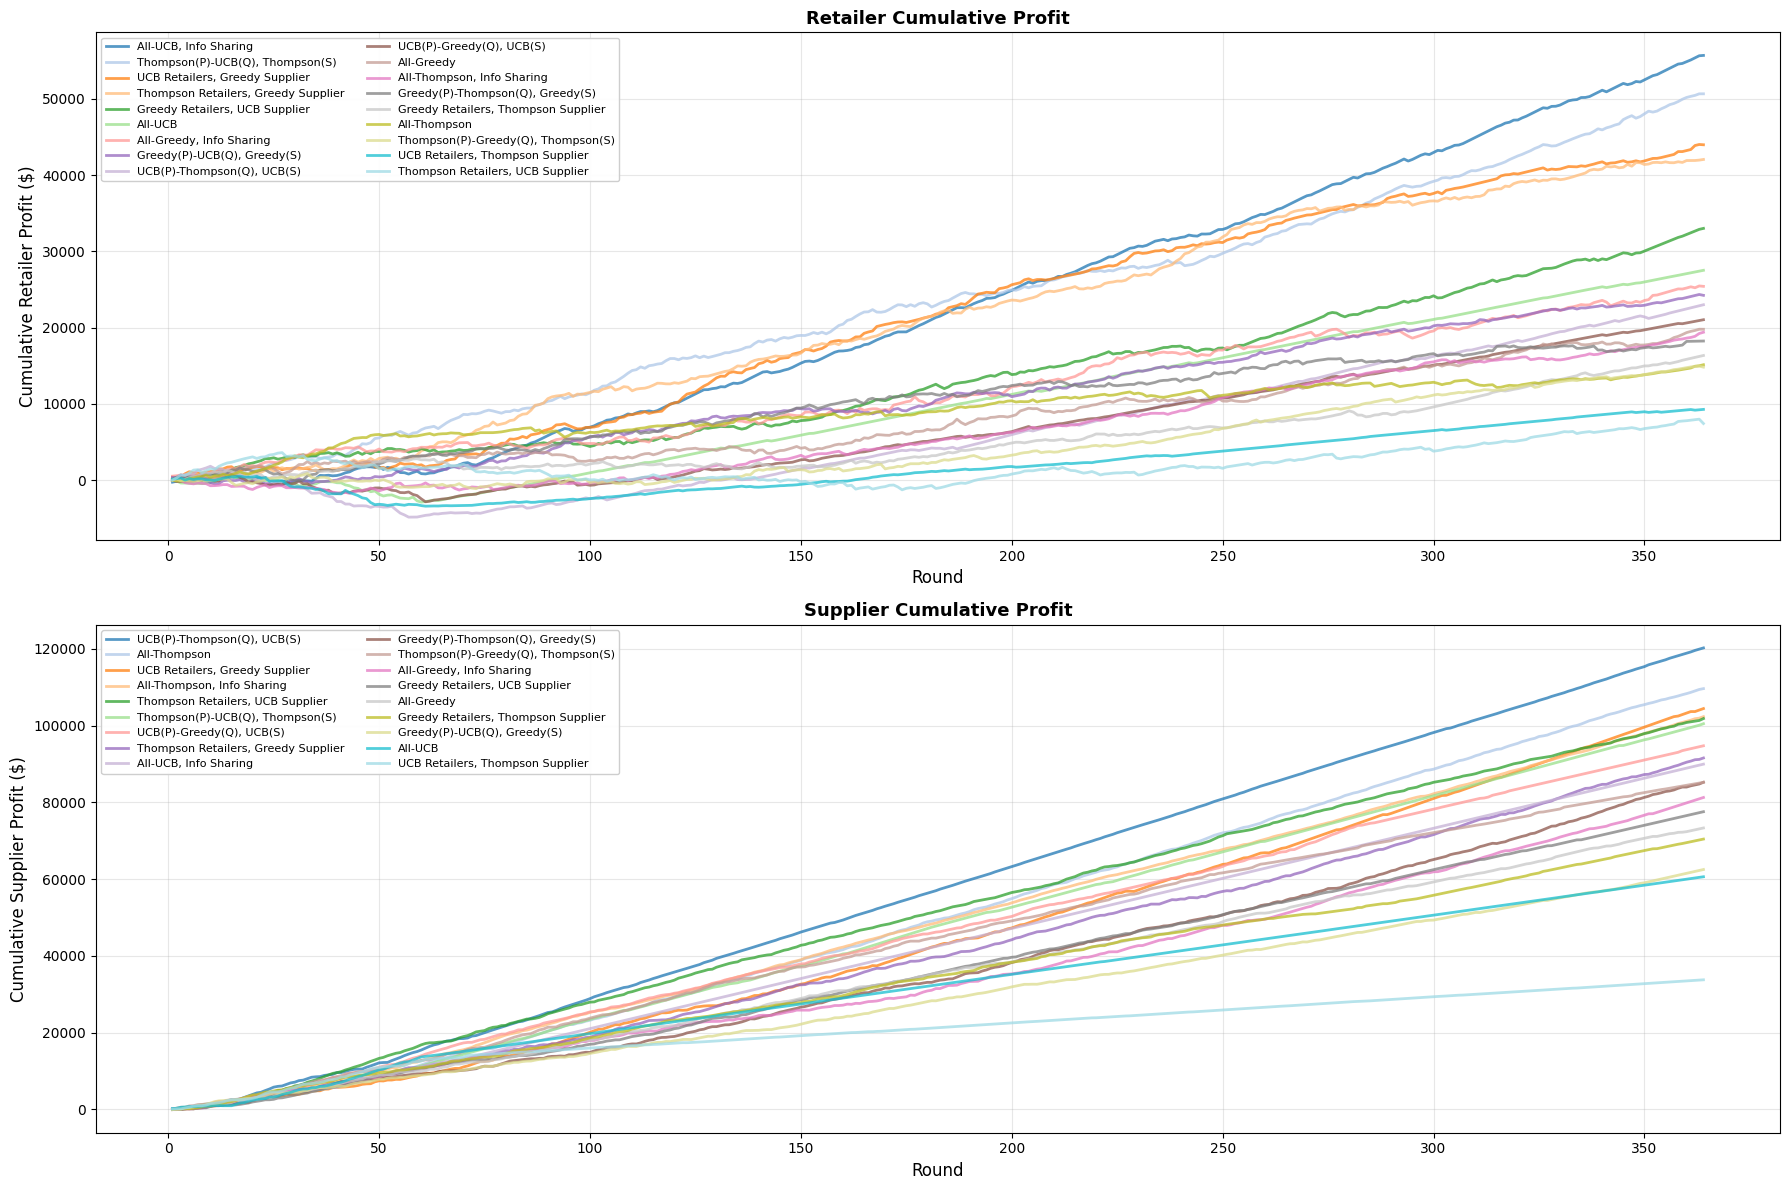

✓ Displayed retailer and supplier profit distributions


In [11]:
# ============================================================================
# VISUALIZATION 10: Competitive Supplier - Retailer vs Supplier Profit Split
# ============================================================================

print("\n📊 GRAPH 10: Competitive Supplier - Profit Distribution")
print("Compare how profit is split between retailer and supplier\n")

fig, axes = plt.subplots(2, 1, figsize=(18, 12))

# Sort by retailer profit
sorted_by_retailer = sorted(competitive_results, key=lambda x: x['Avg_Retailer_Profit'], reverse=True)

colors = plt.cm.tab20(np.linspace(0, 1, len(sorted_by_retailer)))

# Top plot: Retailer profit
for idx, result in enumerate(sorted_by_retailer):
    df = result['Combined_DF']
    cumulative_retailer_profit = df['Retailer_Profit'].cumsum()
    
    axes[0].plot(df['Step'], cumulative_retailer_profit, 
                 label=result['Config'], 
                 color=colors[idx],
                 linewidth=2,
                 alpha=0.75)

axes[0].set_xlabel('Round', fontsize=12)
axes[0].set_ylabel('Cumulative Retailer Profit ($)', fontsize=12)
axes[0].set_title('Retailer Cumulative Profit', fontsize=13, fontweight='bold')
axes[0].legend(loc='upper left', fontsize=8, framealpha=0.95, ncol=2)
axes[0].grid(True, alpha=0.3)

# Bottom plot: Supplier profit
sorted_by_supplier = sorted(competitive_results, key=lambda x: x['Avg_Supplier_Profit'], reverse=True)
colors_supplier = plt.cm.tab20(np.linspace(0, 1, len(sorted_by_supplier)))

for idx, result in enumerate(sorted_by_supplier):
    df = result['Combined_DF']
    cumulative_supplier_profit = df['Supplier_Profit'].cumsum()
    
    axes[1].plot(df['Step'], cumulative_supplier_profit, 
                 label=result['Config'], 
                 color=colors_supplier[idx],
                 linewidth=2,
                 alpha=0.75)

axes[1].set_xlabel('Round', fontsize=12)
axes[1].set_ylabel('Cumulative Supplier Profit ($)', fontsize=12)
axes[1].set_title('Supplier Cumulative Profit', fontsize=13, fontweight='bold')
axes[1].legend(loc='upper left', fontsize=8, framealpha=0.95, ncol=2)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Displayed retailer and supplier profit distributions")


📊 GRAPH 9: Competitive Supplier - Total Supply Chain Profit
Compare cumulative total profit (Retailer + Supplier)



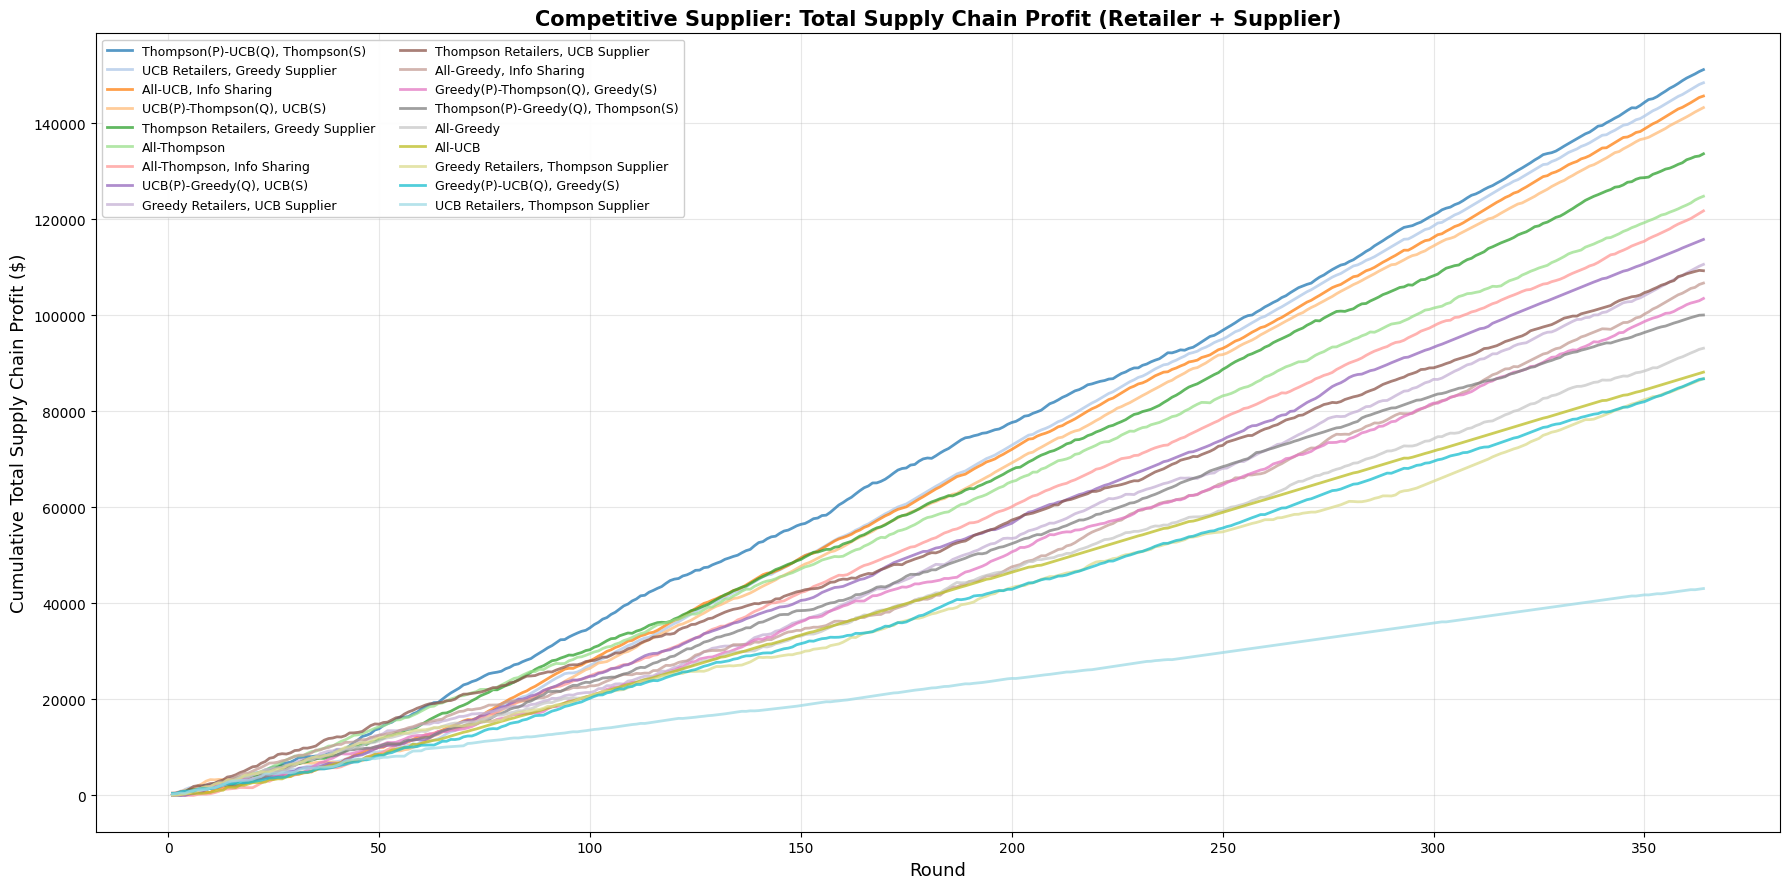

✓ Displayed 18 configurations by total supply chain profit


In [12]:
# ============================================================================
# VISUALIZATION 9: Competitive Supplier - Supply Chain Profit (PROFIT)
# ============================================================================

print("\n📊 GRAPH 9: Competitive Supplier - Total Supply Chain Profit")
print("Compare cumulative total profit (Retailer + Supplier)\n")

fig, ax = plt.subplots(figsize=(18, 9))

# Sort by total supply chain profit
sorted_configs = sorted(competitive_results, key=lambda x: x['Total_Supply_Chain_Profit'], reverse=True)

colors = plt.cm.tab20(np.linspace(0, 1, len(sorted_configs)))

for idx, result in enumerate(sorted_configs):
    df = result['Combined_DF']
    cumulative_total_profit = (df['Retailer_Profit'] + df['Supplier_Profit']).cumsum()
    
    ax.plot(df['Step'], cumulative_total_profit, 
            label=result['Config'], 
            color=colors[idx],
            linewidth=2,
            alpha=0.75)

ax.set_xlabel('Round', fontsize=13)
ax.set_ylabel('Cumulative Total Supply Chain Profit ($)', fontsize=13)
ax.set_title('Competitive Supplier: Total Supply Chain Profit (Retailer + Supplier)', fontsize=15, fontweight='bold')
ax.legend(loc='upper left', fontsize=9, framealpha=0.95, ncol=2)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"✓ Displayed {len(sorted_configs)} configurations by total supply chain profit")


📊 GRAPH 8: Competitive Supplier - Effect of Supplier Algorithm
Compare how different supplier algorithms affect retailer performance



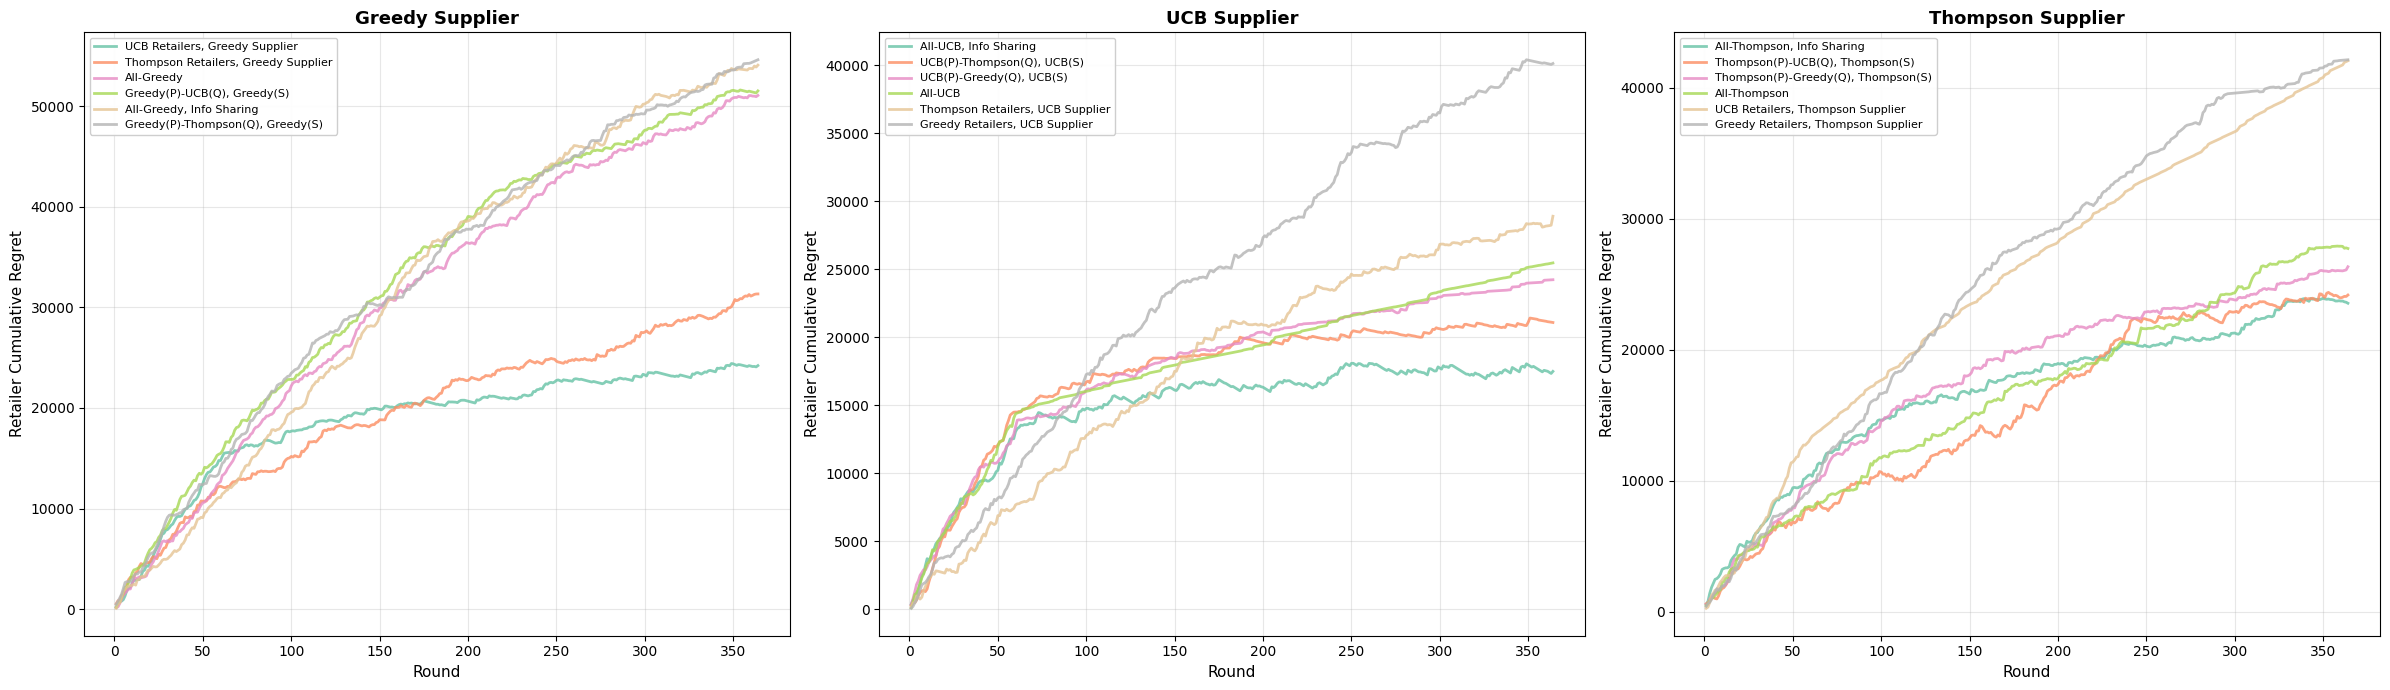

✓ Displayed configurations grouped by supplier algorithm


In [13]:
# ============================================================================
# VISUALIZATION 8: Competitive Supplier - By Supplier Algorithm (REGRET)
# ============================================================================

print("\n📊 GRAPH 8: Competitive Supplier - Effect of Supplier Algorithm")
print("Compare how different supplier algorithms affect retailer performance\n")

fig, axes = plt.subplots(1, 3, figsize=(24, 7))

supplier_types = ['greedy', 'ucb', 'thompson']
supplier_names = ['Greedy Supplier', 'UCB Supplier', 'Thompson Supplier']

for idx, (supplier_type, supplier_name) in enumerate(zip(supplier_types, supplier_names)):
    ax = axes[idx]
    
    # Filter by supplier type
    supplier_configs = [r for r in competitive_results if r['Supplier_Agent'] == supplier_type]
    supplier_configs = sorted(supplier_configs, key=lambda x: x['Retailer_Cumulative_Regret'])
    
    colors = plt.cm.Set2(np.linspace(0, 1, len(supplier_configs)))
    
    for i, result in enumerate(supplier_configs):
        df = result['Combined_DF']
        ax.plot(df['Step'], df['Retailer_Cumulative_Regret'], 
                label=result['Config'], 
                color=colors[i],
                linewidth=2,
                alpha=0.8)
    
    ax.set_xlabel('Round', fontsize=11)
    ax.set_ylabel('Retailer Cumulative Regret', fontsize=11)
    ax.set_title(f'{supplier_name}', fontsize=13, fontweight='bold')
    ax.legend(loc='upper left', fontsize=8, framealpha=0.95)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Displayed configurations grouped by supplier algorithm")

In [14]:
# ============================================================================
# SUMMARY ANALYSIS
# ============================================================================

print("=" * 80)
print("🔍 EXPERIMENT SUMMARY & KEY FINDINGS")
print("=" * 80)

# GROUP 1: Team Player Analysis
print("\n" + "=" * 80)
print("GROUP 1: TEAM PLAYER SUPPLIER (Integrated Supply Chain)")
print("=" * 80)

best_team = min(team_player_results, key=lambda x: x['Cumulative_Regret'])
print(f"\n✅ BEST CONFIGURATION (Lowest Regret):")
print(f"   {best_team['Config']}")
print(f"   Cumulative Regret: {best_team['Cumulative_Regret']:.2f}")
print(f"   Average Profit: {best_team['Avg_Profit']:.2f}")
print(f"   Final Price: {best_team['Final_Price']:.2f}, Quantity: {best_team['Final_Quantity']:.1f}")

# Effect of partner prediction in team player mode
no_pred_team = [r for r in team_player_results if not r['Prediction']]
with_pred_team = [r for r in team_player_results if r['Prediction']]

if with_pred_team and no_pred_team:
    avg_regret_no = np.mean([r['Cumulative_Regret'] for r in no_pred_team])
    avg_regret_with = np.mean([r['Cumulative_Regret'] for r in with_pred_team])
    print(f"\n📊 EFFECT OF PARTNER PREDICTION:")
    print(f"   Without: Avg Regret = {avg_regret_no:.2f}")
    print(f"   With:    Avg Regret = {avg_regret_with:.2f}")
    if avg_regret_no > 0:
        improvement = ((avg_regret_no - avg_regret_with) / avg_regret_no * 100)
        print(f"   Improvement: {improvement:.1f}% reduction in regret")

# GROUP 2: Competitive Analysis
print("\n" + "=" * 80)
print("GROUP 2: COMPETITIVE SUPPLIER (Three-Agent Game)")
print("=" * 80)

best_comp = min(competitive_results, key=lambda x: x['Retailer_Cumulative_Regret'])
print(f"\n✅ BEST FOR RETAILER (Lowest Retailer Regret):")
print(f"   {best_comp['Config']}")
print(f"   Retailer Regret: {best_comp['Retailer_Cumulative_Regret']:.2f}, Profit: {best_comp['Avg_Retailer_Profit']:.2f}")
print(f"   Supplier Profit: {best_comp['Avg_Supplier_Profit']:.2f}")

best_supplier_profit = max(competitive_results, key=lambda x: x['Avg_Supplier_Profit'])
print(f"\n✅ BEST FOR SUPPLIER (Highest Supplier Profit):")
print(f"   {best_supplier_profit['Config']}")
print(f"   Supplier Profit: {best_supplier_profit['Avg_Supplier_Profit']:.2f}")
print(f"   Retailer Regret: {best_supplier_profit['Retailer_Cumulative_Regret']:.2f}, Profit: {best_supplier_profit['Avg_Retailer_Profit']:.2f}")

best_total = max(competitive_results, key=lambda x: x['Total_Supply_Chain_Profit'])
print(f"\n✅ BEST SUPPLY CHAIN EFFICIENCY (Highest Total Profit):")
print(f"   {best_total['Config']}")
print(f"   Total Profit: {best_total['Total_Supply_Chain_Profit']:.2f}")
print(f"   Retailer: {best_total['Avg_Retailer_Profit']:.2f} ({best_total['Avg_Retailer_Profit']/best_total['Total_Supply_Chain_Profit']*100:.1f}%)")
print(f"   Supplier: {best_total['Avg_Supplier_Profit']:.2f} ({best_total['Avg_Supplier_Profit']/best_total['Total_Supply_Chain_Profit']*100:.1f}%)")

# COMPARISON: Team Player vs Competitive
print("\n" + "=" * 80)
print("COMPARISON: TEAM PLAYER vs COMPETITIVE SUPPLIER")
print("=" * 80)

avg_team_profit = np.mean([r['Avg_Profit'] for r in team_player_results])
avg_comp_total_profit = np.mean([r['Total_Supply_Chain_Profit'] for r in competitive_results])
avg_comp_retailer_profit = np.mean([r['Avg_Retailer_Profit'] for r in competitive_results])

print(f"\nTeam Player Mode:")
print(f"  Average Retailer Profit: {avg_team_profit:.2f}")
print(f"\nCompetitive Mode:")
print(f"  Average Total Supply Chain Profit: {avg_comp_total_profit:.2f}")
print(f"  Average Retailer Profit: {avg_comp_retailer_profit:.2f}")
print(f"  Average Supplier Profit: {np.mean([r['Avg_Supplier_Profit'] for r in competitive_results]):.2f}")

if avg_team_profit > 0:
    efficiency_loss = ((avg_team_profit - avg_comp_total_profit) / avg_team_profit * 100)
    print(f"\n💡 Double Marginalization Effect:")
    print(f"  Supply chain loses {efficiency_loss:.1f}% efficiency due to supplier markup")
    print(f"  Retailer profit decreases by {((avg_team_profit - avg_comp_retailer_profit) / avg_team_profit * 100):.1f}%")

print("\n" + "=" * 80)

🔍 EXPERIMENT SUMMARY & KEY FINDINGS

GROUP 1: TEAM PLAYER SUPPLIER (Integrated Supply Chain)

✅ BEST CONFIGURATION (Lowest Regret):
   Thompson-Thompson, With Prediction
   Cumulative Regret: 21888.00
   Average Profit: 475.75
   Final Price: 18.27, Quantity: 38.1

📊 EFFECT OF PARTNER PREDICTION:
   Without: Avg Regret = 51241.96
   With:    Avg Regret = 47489.65
   Improvement: 7.3% reduction in regret

GROUP 2: COMPETITIVE SUPPLIER (Three-Agent Game)

✅ BEST FOR RETAILER (Lowest Retailer Regret):
   All-UCB, Info Sharing
   Retailer Regret: 17490.91, Profit: 153.02
   Supplier Profit: 247.10

✅ BEST FOR SUPPLIER (Highest Supplier Profit):
   UCB(P)-Thompson(Q), UCB(S)
   Supplier Profit: 330.29
   Retailer Regret: 21087.56, Profit: 63.22

✅ BEST SUPPLY CHAIN EFFICIENCY (Highest Total Profit):
   Thompson(P)-UCB(Q), Thompson(S)
   Total Profit: 415.24
   Retailer: 139.19 (33.5%)
   Supplier: 276.05 (66.5%)

COMPARISON: TEAM PLAYER vs COMPETITIVE SUPPLIER

Team Player Mode:
  Average R

In [15]:
# Create Summary Tables

print("\n📋 GROUP 1: TEAM PLAYER SUPPLIER - Summary Table")
team_df = pd.DataFrame([{k: v for k, v in r.items() if k != 'Combined_DF'} for r in team_player_results])
display(team_df[['Config', 'Cumulative_Regret', 'Avg_Profit', 'Final_Price', 'Final_Quantity', 'Prediction']])

print("\n📋 GROUP 2: COMPETITIVE SUPPLIER - Summary Table")
comp_df = pd.DataFrame([{k: v for k, v in r.items() if k != 'Combined_DF'} for r in competitive_results])
display(comp_df[['Config', 'Retailer_Cumulative_Regret', 'Avg_Retailer_Profit', 'Avg_Supplier_Profit', 
                  'Total_Supply_Chain_Profit', 'Final_Cost', 'Prediction']])


📋 GROUP 1: TEAM PLAYER SUPPLIER - Summary Table


Config  Cumulative_Regret  Avg_Profit  \
0             Greedy-Greedy, No Prediction       73678.017290  334.041852   
1           Greedy-Greedy, With Prediction       72459.621531  338.389177   
2                   UCB-UCB, No Prediction       48419.950522  403.467860   
3                 UCB-UCB, With Prediction       47260.572016  407.390598   
4         Thompson-Thompson, No Prediction       34914.953228  440.357957   
5       Thompson-Thompson, With Prediction       21887.996394  475.747948   
6          Greedy(P)-UCB(Q), No Prediction       61748.469853  367.040520   
7        Greedy(P)-UCB(Q), With Prediction       58004.033314  377.122847   
8          UCB(P)-Greedy(Q), No Prediction       55101.374716  385.082681   
9        UCB(P)-Greedy(Q), With Prediction       55221.096660  385.673497   
10    Greedy(P)-Thompson(Q), No Prediction       55863.742198  383.628033   
11  Greedy(P)-Thompson(Q), With Prediction       60136.688103  371.518739   
12    Thompson(P)-Greedy(Q), No Prediction       60222.494665  371.584583   
13  Thompson(P)-Greedy(Q), With Prediction       56541.302252  380.771833   
14       Thompson(P)-UCB(Q), No Prediction       37271.765850  433.953252   
15     Thompson(P)-UCB(Q), With Prediction       24188.711042  469.744894   
16       UCB(P)-Thompson(Q), No Prediction       33956.869681  444.175823   
17     UCB(P)-Thompson(Q), With Prediction       31706.798623  449.900964   

    Final_Price  Final_Quantity  Prediction  
0        19.535           36.15       False  
1        18.255           34.60        True  
2        20.000           29.00       False  
3        19.000           29.00        True  
4        19.495           31.70       False  
5        18.275           38.09        True  
6        17.260           33.00       False  
7        16.885           37.00        True  
8        19.000           31.51       False  
9        18.000           33.06        True  
10       18.520           36.10       False  
11       17.990           35.27        True  
12       19.615           33.94       False  
13       17.930           35.99        True  
14       17.075           37.00       False  
15       17.925           38.87        True  
16       19.500           36.31       False  
17       16.000           39.64        True


📋 GROUP 2: COMPETITIVE SUPPLIER - Summary Table


Config  Retailer_Cumulative_Regret  \
0                            All-Greedy                51071.443381   
1              All-Greedy, Info Sharing                54086.021925   
2                               All-UCB                25470.950237   
3                 All-UCB, Info Sharing                17490.912569   
4                          All-Thompson                27717.984347   
5            All-Thompson, Info Sharing                23540.453544   
6        Greedy Retailers, UCB Supplier                40138.085804   
7   Greedy Retailers, Thompson Supplier                42120.458675   
8        UCB Retailers, Greedy Supplier                24208.304595   
9      UCB Retailers, Thompson Supplier                42042.987648   
10  Thompson Retailers, Greedy Supplier                31334.126232   
11     Thompson Retailers, UCB Supplier                28903.199737   
12          Greedy(P)-UCB(Q), Greedy(S)                51522.817084   
13     Greedy(P)-Thompson(Q), Greedy(S)                54619.754066   
14             UCB(P)-Greedy(Q), UCB(S)                24233.523758   
15           UCB(P)-Thompson(Q), UCB(S)                21087.556392   
16   Thompson(P)-Greedy(Q), Thompson(S)                26326.838048   
17      Thompson(P)-UCB(Q), Thompson(S)                24167.572497   

    Avg_Retailer_Profit  Avg_Supplier_Profit  Total_Supply_Chain_Profit  \
0             54.378923           201.417582                 255.796505   
1             69.844123           223.241758                 293.085881   
2             75.621348           166.500000                 242.121348   
3            153.023607           247.104396                 400.128003   
4             41.615654           301.153846                 342.769501   
5             53.317321           281.087912                 334.405233   
6             90.722513           213.060440                 303.782953   
7             44.946360           193.472527                 238.418888   
8            120.840098           286.879121                 407.719219   
9             25.524356            92.752747                 118.277103   
10           115.545998           251.521978                 367.067976   
11            20.437516           279.714286                 300.151802   
12            66.602861           171.684066                 238.286927   
13            50.150396           234.134615                 284.285011   
14            57.819649           260.241758                 318.061407   
15            63.218029           330.285714                 393.503743   
16            40.747326           234.068681                 274.816007   
17           139.193628           276.046703                 415.240331   

    Final_Cost  Prediction  
0        12.83       False  
1        12.61        True  
2        13.13       False  
3        11.00        True  
4        15.00       False  
5        14.54        True  
6        11.00       False  
7        12.68       False  
8        14.14       False  
9        13.45       False  
10       13.46       False  
11       15.00       False  
12       13.48       False  
13       14.06       False  
14       14.00       False  
15       14.00       False  
16       14.63       False  
17       10.93       False

🔍 DIAGNOSTIC: SUPPLIER COST ANALYSIS

Analyzing: All-Greedy

1. SUPPLIER COST STATISTICS:
   Mean Cost: 11.54
   Median Cost: 14.00
   Min Cost: 0.00
   Max Cost: 15.00
   Std Dev: 4.00
   Max Ceiling: 15.00

2. RETAILER PROFIT STATISTICS:
   Mean Profit: 54.38
   Median Profit: 63.80
   Min Profit: -462.00
   Max Profit: 546.31
   Days with positive profit: 233 / 364 (64.0%)
   Days with negative profit: 121 / 364 (33.2%)

3. SUPPLIER PROFIT STATISTICS:
   Mean Profit: 201.42
   Median Profit: 240.00
   Min Profit: -78.00
   Max Profit: 480.00

4. BENCHMARKS:
   SUPPLIER_OPTIMAL_COST: 15.00
   MANUFACTURING_COST: 2.00
   SUPPLIER_MAX_COST (Ceiling): 15.00

5. EARLY ROUNDS (First 50 days):
   Avg Supplier Cost: 9.52
   Avg Retailer Profit: 47.87
   Avg Supplier Profit: 178.36

6. LATE ROUNDS (Last 50 days):
   Avg Supplier Cost: 12.92
   Avg Retailer Profit: 80.24
   Avg Supplier Profit: 222.60


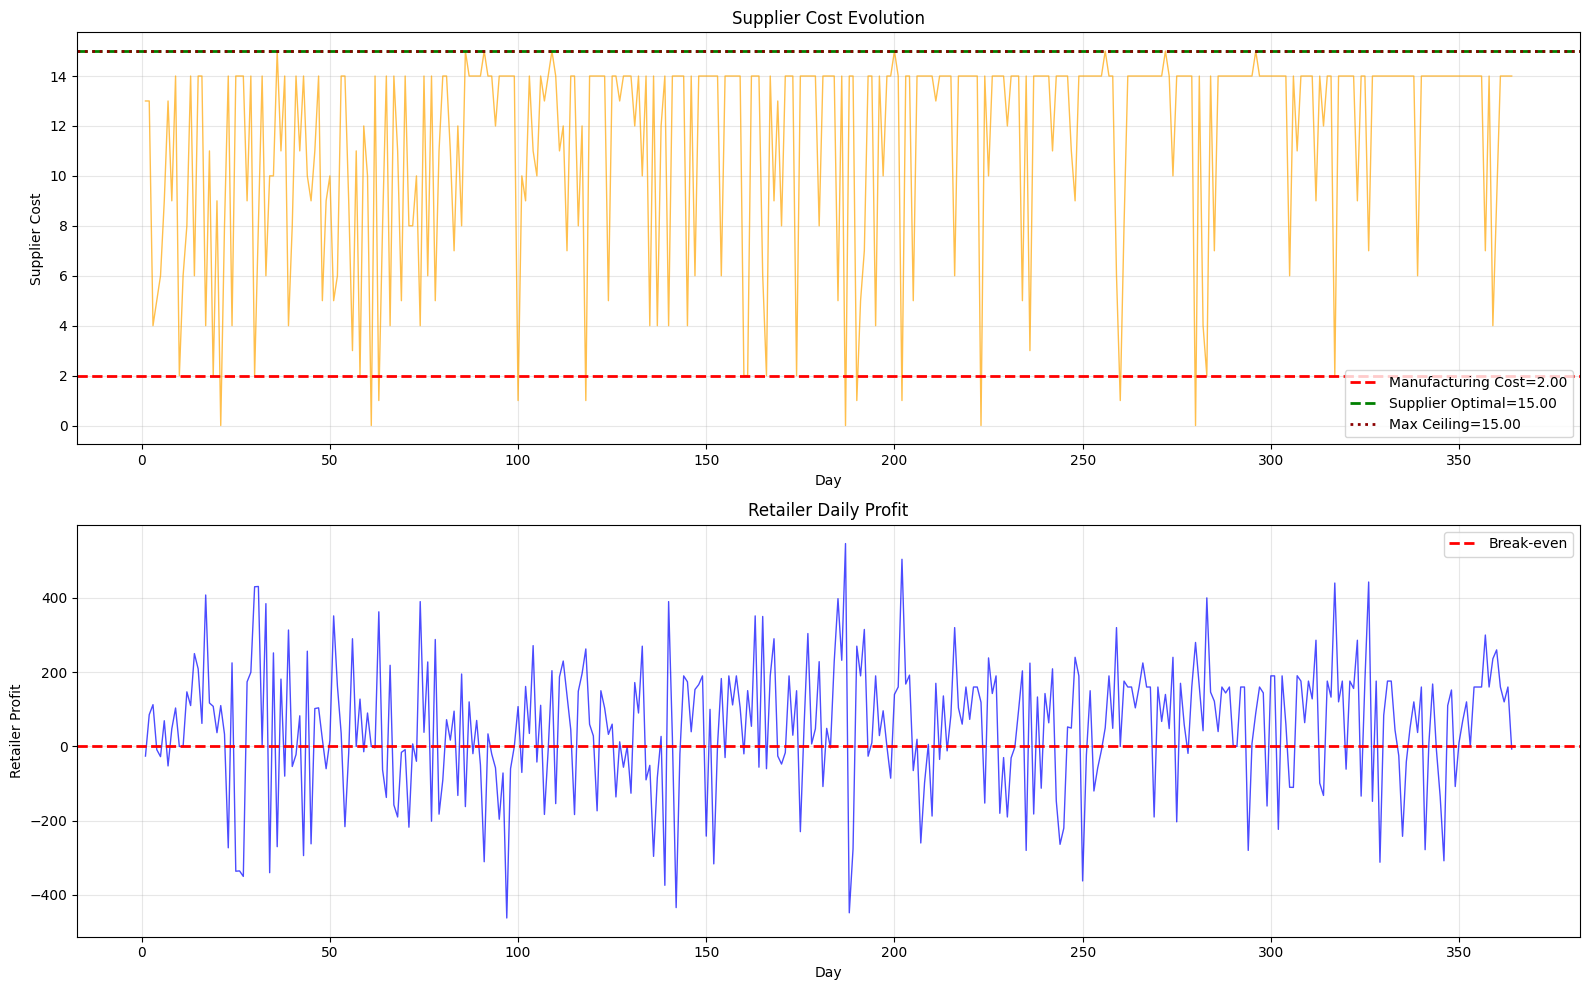


7. PROBLEM DIAGNOSIS:
   ✅ Average retailer profit is POSITIVE
      - Supplier cost ceiling is working effectively
   ⚠️ Only 64.0% of days have positive retailer profit
      - Supplier is still exploring high costs during learning



In [16]:
# ============================================================================
# DIAGNOSTIC: Analyze Supplier Behavior
# ============================================================================

print("=" * 80)
print("🔍 DIAGNOSTIC: SUPPLIER COST ANALYSIS")
print("=" * 80)

if len(competitive_results) > 0:
    # Pick first competitive result to analyze
    sample_result = competitive_results[0]
    df = sample_result['Combined_DF']
    
    print(f"\nAnalyzing: {sample_result['Config']}")
    print(f"\n1. SUPPLIER COST STATISTICS:")
    print(f"   Mean Cost: {df['Cost'].mean():.2f}")
    print(f"   Median Cost: {df['Cost'].median():.2f}")
    print(f"   Min Cost: {df['Cost'].min():.2f}")
    print(f"   Max Cost: {df['Cost'].max():.2f}")
    print(f"   Std Dev: {df['Cost'].std():.2f}")
    print(f"   Max Ceiling: {params.SUPPLIER_MAX_COST:.2f}")
    
    print(f"\n2. RETAILER PROFIT STATISTICS:")
    print(f"   Mean Profit: {df['Retailer_Profit'].mean():.2f}")
    print(f"   Median Profit: {df['Retailer_Profit'].median():.2f}")
    print(f"   Min Profit: {df['Retailer_Profit'].min():.2f}")
    print(f"   Max Profit: {df['Retailer_Profit'].max():.2f}")
    print(f"   Days with positive profit: {(df['Retailer_Profit'] > 0).sum()} / {len(df)} ({(df['Retailer_Profit'] > 0).sum()/len(df)*100:.1f}%)")
    print(f"   Days with negative profit: {(df['Retailer_Profit'] < 0).sum()} / {len(df)} ({(df['Retailer_Profit'] < 0).sum()/len(df)*100:.1f}%)")
    
    print(f"\n3. SUPPLIER PROFIT STATISTICS:")
    print(f"   Mean Profit: {df['Supplier_Profit'].mean():.2f}")
    print(f"   Median Profit: {df['Supplier_Profit'].median():.2f}")
    print(f"   Min Profit: {df['Supplier_Profit'].min():.2f}")
    print(f"   Max Profit: {df['Supplier_Profit'].max():.2f}")
    
    print(f"\n4. BENCHMARKS:")
    print(f"   SUPPLIER_OPTIMAL_COST: {params.SUPPLIER_OPTIMAL_COST:.2f}")
    print(f"   MANUFACTURING_COST: {params.MANUFACTURING_COST:.2f}")
    print(f"   SUPPLIER_MAX_COST (Ceiling): {params.SUPPLIER_MAX_COST:.2f}")
    
    print(f"\n5. EARLY ROUNDS (First 50 days):")
    early = df.head(50)
    print(f"   Avg Supplier Cost: {early['Cost'].mean():.2f}")
    print(f"   Avg Retailer Profit: {early['Retailer_Profit'].mean():.2f}")
    print(f"   Avg Supplier Profit: {early['Supplier_Profit'].mean():.2f}")
    
    print(f"\n6. LATE ROUNDS (Last 50 days):")
    late = df.tail(50)
    print(f"   Avg Supplier Cost: {late['Cost'].mean():.2f}")
    print(f"   Avg Retailer Profit: {late['Retailer_Profit'].mean():.2f}")
    print(f"   Avg Supplier Profit: {late['Supplier_Profit'].mean():.2f}")
    
    # Plot supplier cost and retailer profit evolution
    fig, axes = plt.subplots(2, 1, figsize=(16, 10))
    
    # Supplier Cost over time
    axes[0].plot(df['Step'], df['Cost'], alpha=0.7, linewidth=1, color='orange')
    axes[0].axhline(params.MANUFACTURING_COST, color='red', linestyle='--', linewidth=2, label=f'Manufacturing Cost={params.MANUFACTURING_COST:.2f}')
    axes[0].axhline(params.SUPPLIER_OPTIMAL_COST, color='green', linestyle='--', linewidth=2, label=f'Supplier Optimal={params.SUPPLIER_OPTIMAL_COST:.2f}')
    axes[0].axhline(params.SUPPLIER_MAX_COST, color='darkred', linestyle=':', linewidth=2, label=f'Max Ceiling={params.SUPPLIER_MAX_COST:.2f}')
    axes[0].set_xlabel('Day')
    axes[0].set_ylabel('Supplier Cost')
    axes[0].set_title('Supplier Cost Evolution')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Retailer Profit over time
    axes[1].plot(df['Step'], df['Retailer_Profit'], alpha=0.7, linewidth=1, color='blue')
    axes[1].axhline(0, color='red', linestyle='--', linewidth=2, label='Break-even')
    axes[1].set_xlabel('Day')
    axes[1].set_ylabel('Retailer Profit')
    axes[1].set_title('Retailer Daily Profit')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Check if supplier is charging too much
    print(f"\n7. PROBLEM DIAGNOSIS:")
    if df['Retailer_Profit'].mean() < 0:
        print("   ⚠️ WARNING: Average retailer profit is NEGATIVE")
        print(f"      - Supplier avg cost ({df['Cost'].mean():.2f}) may be too high")
        print(f"      - Consider lowering SUPPLIER_MAX_COST further")
    else:
        print("   ✅ Average retailer profit is POSITIVE")
        print(f"      - Supplier cost ceiling is working effectively")
    
    positive_pct = (df['Retailer_Profit'] > 0).sum() / len(df) * 100
    if positive_pct < 80:
        print(f"   ⚠️ Only {positive_pct:.1f}% of days have positive retailer profit")
        print(f"      - Supplier is still exploring high costs during learning")
    else:
        print(f"   ✅ {positive_pct:.1f}% of days have positive retailer profit")

print("\n" + "=" * 80)

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Configuration</th>
      <th>Cumulative Regret</th>
      <th>Average Profit</th>
      <th>Final Price</th>
      <th>Final Quantity</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>All-Greedy (No Sharing)</td>
      <td>76863.12</td>
      <td>325.07</td>
      <td>18.50</td>
      <td>33.5</td>
    </tr>
    <tr>
      <th>1</th>
      <td>All-UCB (No Sharing)</td>
      <td>34077.10</td>
      <td>442.93</td>
      <td>20.00</td>
      <td>39.0</td>
    </tr>
    <tr>
      <th>2</th>
      <td>All-Thompson (No Sharing)</td>
      <td>37480.86</td>
      <td>433.23</td>
      <td>19.05</td>
      <td>37.0</td>
    </tr>
    <tr>
      <th>3</th>
      <td>All-Greedy (With Sharing)</td>
      <td>68953.72</td>
      <td>346.98</td>
      <td>18.19</td>
      <td>33.8</td>
    </tr>
    <tr>
      <th>4</th>
      <td>All-UCB (With Sharing)</td>
      <td>32635.75</td>
      <td>446.74</td>
      <td>18.50</td>
      <td>34.0</td>
    </tr>
    <tr>
      <th>5</th>
      <td>All-Thompson (With Sharing)</td>
      <td>25016.61</td>
      <td>467.56</td>
      <td>18.04</td>
      <td>35.8</td>
    </tr>
    <tr>
      <th>6</th>
      <td>All-LLM (With Sharing)</td>
      <td>135458.60</td>
      <td>165.29</td>
      <td>20.02</td>
      <td>7.2</td>
    </tr>
  </tbody>
</table>
</div>